## 1. Importar las Librerías Necesarias

In [144]:
# Librerias basicas 
import numpy as np 
import pandas as pd 
import os

# Visualizacióon
import matplotlib.pyplot as plt
import seaborn as sns 
from plotly import express as px

# Librerias analisis de texto
from wordcloud import WordCloud

# Funciones auxiliares sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold #Split y cross Validation
from sklearn.metrics import cohen_kappa_score, make_scorer, accuracy_score, balanced_accuracy_score, confusion_matrix, roc_curve, auc#Metricas
from sklearn.utils import shuffle 
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_val_predict, GridSearchCV

# Plot de matriz de confusion normalizada en actuals
from utils import plot_confusion_matrix, get_artifact_filename
 
# Models
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier as rfc
import xgboost as xgb

# Guardar modelos
import pickle

# Optimizacion de hiperparametros
import optuna
from optuna.artifacts import FileSystemArtifactStore, upload_artifact

# Para NLP
import spacy
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
from wordcloud import WordCloud
from textblob import TextBlob
import tensorflow as tf
from keybert import KeyBERT
from bertopic import BERTopic
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS
from scipy import stats
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob

# Estandarizar o Normalizar
from sklearn.preprocessing import StandardScaler

# Ensemble
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

#Guardado de objetos en archivos joblib
from joblib import load, dump

%matplotlib inline
pd.set_option('display.max_columns', 30)
plt.rcParams['figure.figsize'] = [12.0, 8.0]

## 2. Leer los Datos


Rutas

In [11]:
#Subimos dos niveles para quedar en la carpeta que contiene input y UA_MDM_LDI_II
BASE_DIR = '../../'

#Datos de entrenamiento 
PATH_TO_TRAIN = os.path.join(BASE_DIR, "input/petfinder-adoption-prediction/train/train.csv")

#CSV colores
PATH_TO_COLOURS = os.path.join(BASE_DIR, "input/petfinder-adoption-prediction/ColorLabels.csv")

#CSV states
PATH_TO_STATES = os.path.join(BASE_DIR, "input/petfinder-adoption-prediction/StateLabels.csv")

#CSV breed
PATH_TO_BREEDS = os.path.join(BASE_DIR, "input/petfinder-adoption-prediction/BreedLabels.csv")

#Salida de modelos entrenados
PATH_TO_MODELS = os.path.join(BASE_DIR, "UA_MDM_LDI_II/work/models")

#Artefactos a subir a optuna
PATH_TO_TEMP_FILES = os.path.join(BASE_DIR, "UA_MDM_LDI_II/work/optuna_temp_artifacts")

#Artefactos que optuna gestiona
PATH_TO_OPTUNA_ARTIFACTS = os.path.join(BASE_DIR, "UA_MDM_LDI_II/work/optuna_artifacts")

Leemos dataset de colores

In [8]:
df_color = pd.read_csv(PATH_TO_COLOURS)
df_color

,ColorID,ColorName
0,1,Black
1,2,Brown
2,3,Golden
3,4,Yellow
4,5,Cream
5,6,Gray
6,7,White


Leemos dataset de ciudades

In [10]:
df_states = pd.read_csv(PATH_TO_STATES)
df_states.head()

,StateID,StateName
0,41336,Johor
1,41325,Kedah
2,41367,Kelantan
3,41401,Kuala Lumpur
4,41415,Labuan


Leemos el dataset de razas

In [12]:
df_razas = pd.read_csv(PATH_TO_BREEDS)
df_razas.head()

,BreedID,Type,BreedName
0,1,1,Affenpinscher
1,2,1,Afghan Hound
2,3,1,Airedale Terrier
3,4,1,Akbash
4,5,1,Akita


Leemos dataset de train

In [3]:
df = pd.read_csv(PATH_TO_TRAIN)

El dataset tiene 25 columnas y 14993 filas

In [5]:
df.shape

(14993, 24)

Primeros 5 registros

In [6]:
df.head() 

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2


Tipos de datos

In [31]:
df.dtypes

Type               int64
Name              object
Age                int64
Breed1             int64
Breed2             int64
Gender             int64
Color1             int64
Color2             int64
Color3             int64
MaturitySize       int64
FurLength          int64
Vaccinated         int64
Dewormed           int64
Sterilized         int64
Health             int64
Quantity           int64
Fee                int64
State              int64
RescuerID         object
VideoAmt           int64
Description       object
PetID             object
PhotoAmt         float64
AdoptionSpeed      int64
Breed1Name        object
Breed2Name        object
Color1Nombre      object
Color2Nombre      object
Color3Nombre      object
TypeNombre        object
dtype: object

Agregamos el nombre de las razas al dataset

In [13]:
# Hacer merge para obtener los nombres de las razas de Breed1 y Breed2
df = df.merge(df_razas, left_on=['Breed1', 'Type'], right_on=['BreedID', 'Type'], how='left')
df = df.rename(columns={'BreedName': 'Breed1Name'})
df = df.merge(df_razas, left_on=['Breed2', 'Type'], right_on=['BreedID', 'Type'], how='left')
df = df.rename(columns={'BreedName': 'Breed2Name'})

In [29]:
df = df.drop(['BreedID_x','BreedID_y'], axis=1)

Agregamos los colores al dataset

In [21]:
# Unir las tablas por COLOR
df = pd.merge(df, df_color, left_on=['Color1'], right_on=['ColorID'], how='left')
df = pd.merge(df, df_color, left_on=['Color2'], right_on=['ColorID'], how='left')
df = pd.merge(df, df_color, left_on=['Color3'], right_on=['ColorID'], how='left')

#Renombro las columnas de color y dejo las númericas
#df = df.drop(['Color1','Color2','Color3','ColorID_x','ColorID_y','ColorID'], axis=1)
df = df.drop(['ColorID_x','ColorID_y','ColorID'], axis=1)
df = df.rename(columns={'ColorName_x':'Color1Nombre','ColorName_y':'Color2Nombre','ColorName':'Color3Nombre'})

Agregamos las ciudades al dataset

In [99]:
# Realizar el left join
df = pd.merge(df, df_states[['StateID', 'StateName']], left_on='State', right_on='StateID', how='left')

# Eliminar la columna 'StateID' ya que solo queremos 'StateName'
df = df.drop(columns=['StateID'])

df[['State','StateName']]

,State,StateName
0,41326,Selangor
1,41401,Kuala Lumpur
2,41326,Selangor
3,41401,Kuala Lumpur
4,41326,Selangor
...,...,...
14988,41326,Selangor
14989,41326,Selangor
14990,41326,Selangor
14991,41336,Johor


Cantidad de NAs

In [40]:
df.isna().sum() 

Type             0
Name             0
Age              0
Breed1           0
Breed2           0
Gender           0
Color1           0
Color2           0
Color3           0
MaturitySize     0
FurLength        0
Vaccinated       0
Dewormed         0
Sterilized       0
Health           0
Quantity         0
Fee              0
State            0
RescuerID        0
VideoAmt         0
Description      0
PetID            0
PhotoAmt         0
AdoptionSpeed    0
Color1Nombre     0
Color2Nombre     0
Color3Nombre     0
TypeNombre       0
tipo_raza        0
raza             0
dtype: int64

Imputamos nombre

In [16]:
df['Name'] = df['Name'].fillna('Unnamed')

Imputamos descripción

In [18]:
df[df['Description'].isnull()]
df['Description'] = df['Description'].fillna('Undescripted')

Imputamos color

In [23]:
df['Color2Nombre'].fillna('None', inplace=True)
df['Color3Nombre'].fillna('None', inplace=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_5752\411585157.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Color2Nombre'].fillna('None', inplace=True)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_5752\411585157.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exam

Tipo de raza: { raza pura , mestizo }

In [34]:
# Función para clasificar el tipo de raza
def clasificar_breed(row):
    if row['Breed1'] == 307 or row['Breed2'] == 307:
        return 'mestizo'
    elif row['Breed1'] == 0 and row['Breed2'] == 0:
        return 'indefinido'
    elif row['Breed1'] == row['Breed2']:
        return 'raza_pura'
    else:
        return 'mestizo'

df['tipo_raza'] = df.apply(clasificar_breed, axis=1)

Nombre de la raza

In [36]:
def setearRaza(row):
    if row['tipo_raza'] == 'raza_pura':
        return row['Breed1Name']
    elif row['tipo_raza'] == 'mestizo':
        return f"{row['Breed1Name']} x {row['Breed2Name']}"
    else:
        return 'N/A'

df['raza'] = df.apply(setearRaza, axis=1)
df = df.drop(['Breed1Name','Breed2Name'], axis=1)

Imputamos razas

In [39]:
# Limpiar la columna 'raza'
df['raza'] = df['raza'].replace('Mixed Breed x Mixed Breed', 'Mixed Breed')
df['raza'] = df['raza'].str.replace(' x nan', '', case=False)
df['raza'] = df['raza'].str.replace('nan x', '', case=False)
df['raza'].fillna('N/A', inplace=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_5752\3377653641.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['raza'].fillna('N/A', inplace=True)


Tipo de mascota

In [24]:
# Mapeamos el Tipo de Mascota
df['TypeNombre'] = df['Type'].apply(lambda x: 'Dog' if x == 1 else 'Cat')

## 3. EDA


### 3.1 Correlograma

Transformamos AdoptionSpeed a entero

In [48]:
# Convertir la variable AdoptionSpeed a entero
df['AdoptionSpeed'] = df['AdoptionSpeed'].astype(int)

# Identificar columnas numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

Creamos un heatmap

Text(0.5, 1.0, 'AdoptionSpeed')

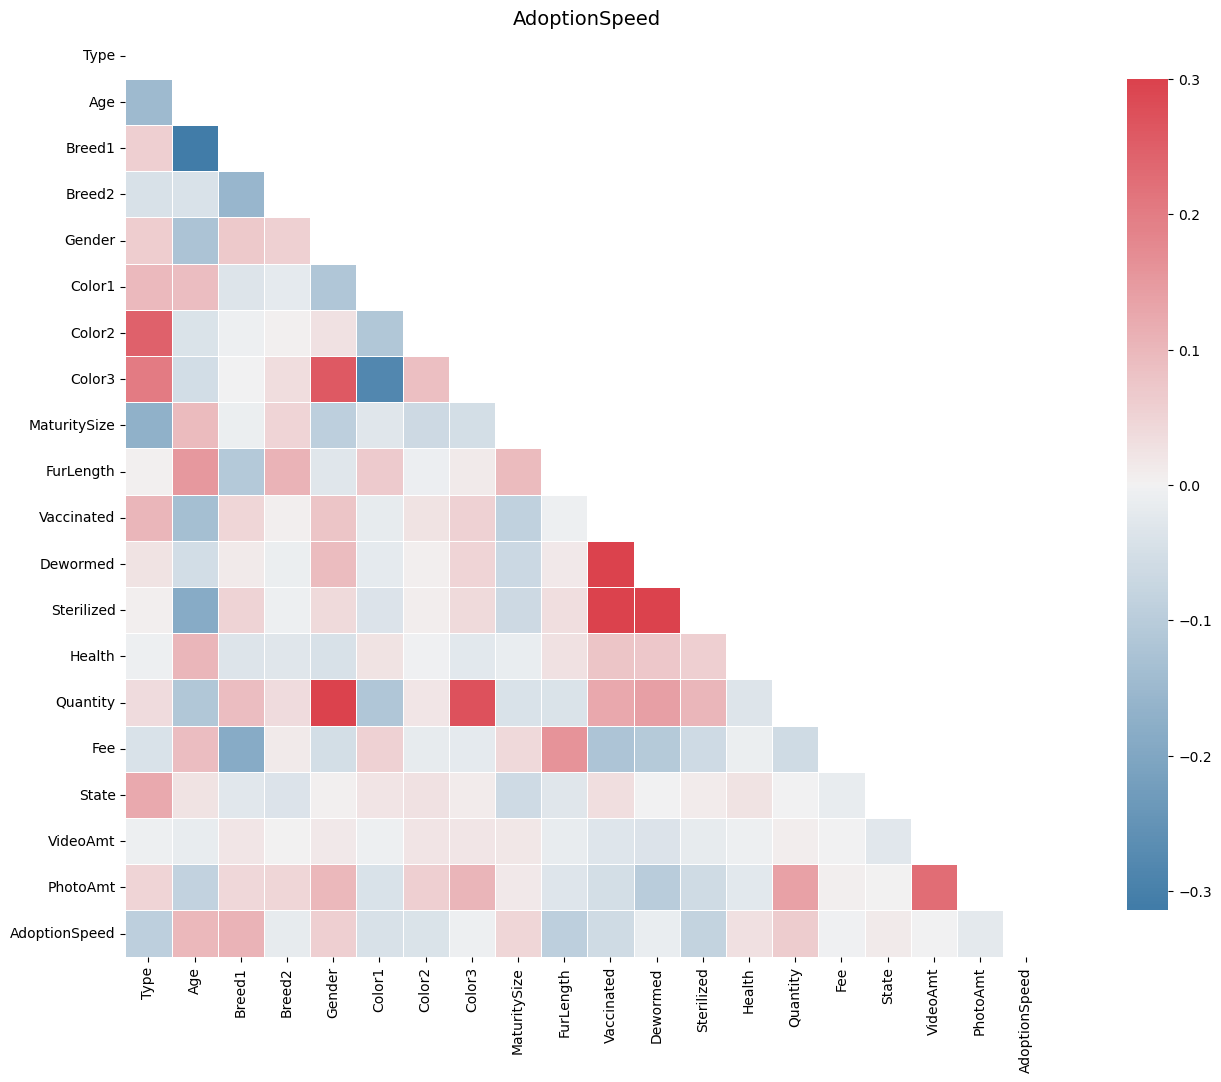

In [49]:
f, ax1 = plt.subplots(1,1,figsize=(20,12))

corr=df[numeric_cols].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(240, 10, as_cmap=True,n=9)




ax1=sns.heatmap(corr, mask=mask, cmap=cmap,  center=0,
            square=True, linewidths=.5,vmax=0.3, cbar_kws={"shrink": .9})
ax1.set_title("AdoptionSpeed",fontsize=14)

In [50]:
corr=df[['Quantity','Gender']].corr()
corr

,Quantity,Gender
Quantity,1.000000,0.494489
Gender,0.494489,1.000000


In [51]:
corr=df[['Sterilized','Vaccinated']].corr()
corr

,Sterilized,Vaccinated
Sterilized,1.000000,0.471204
Vaccinated,0.471204,1.000000


Conclusión: Las siguientes variables tienen correlación media:
- Quantity y Gender correlación positiva (0.49).
- Sterilized y Vaccinated correlación positiva (0.47).

### 3.2 Distribución de la Velocidad de Adopción


Histograma

Text(0.5, 1.0, 'Adoption speed classes counts')

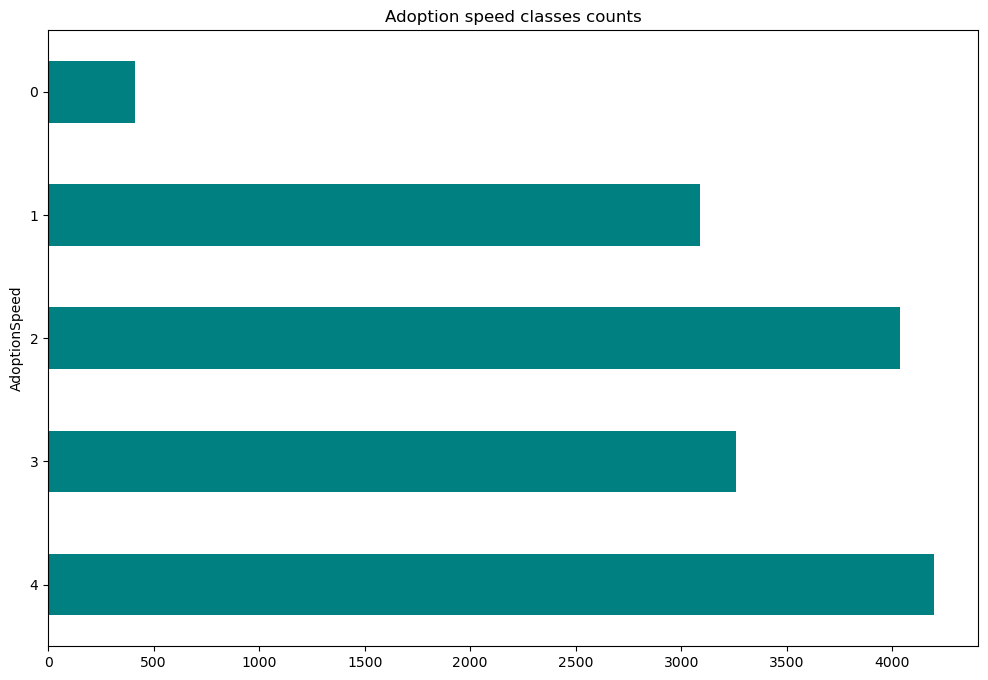

In [43]:
df['AdoptionSpeed'].value_counts().sort_index(ascending = False).plot(kind='barh', color='teal')
plt.title('Adoption speed classes counts')

Histograma con porcentajes

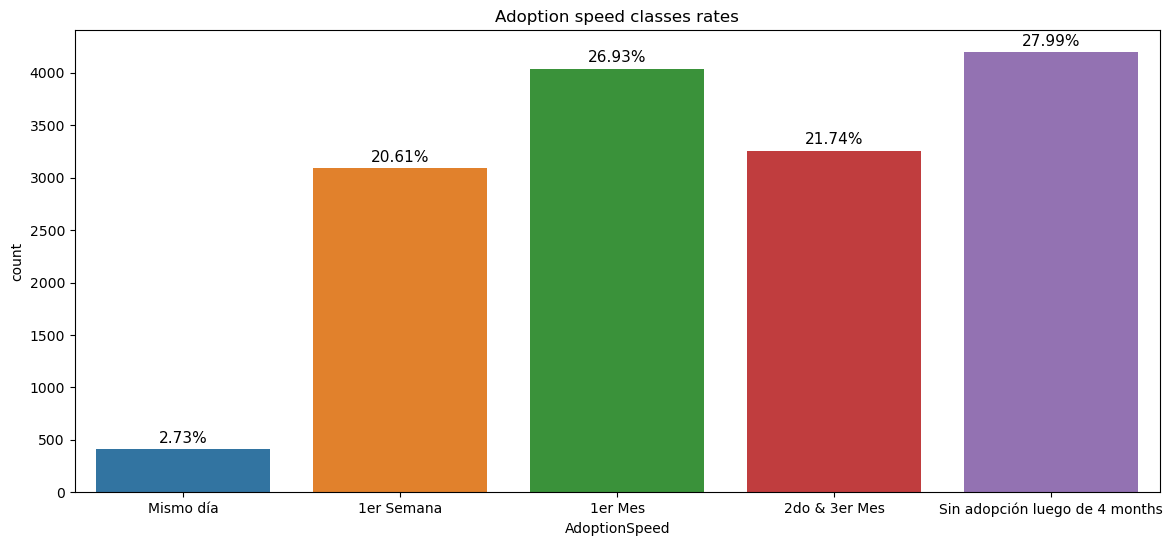

In [46]:
plt.figure(figsize=(14, 6));
g = sns.countplot(x='AdoptionSpeed', data=df)
plt.title('Adoption speed classes rates')
ax=g.axes
for p in ax.patches:
     ax.annotate(f"{p.get_height() * 100 / df.shape[0]:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='black', rotation=0, xytext=(0, 8),
         textcoords='offset points')  
ax=ax.set_xticklabels(['Mismo día', '1er Semana','1er Mes','2do & 3er Mes','Sin adopción luego de 4 months'])

### 3.3 AdoptioSpeed vs Type

Gráfico de barras

Text(0.5, 1.0, 'Number of cats and dogs by AdoptionSpeed')

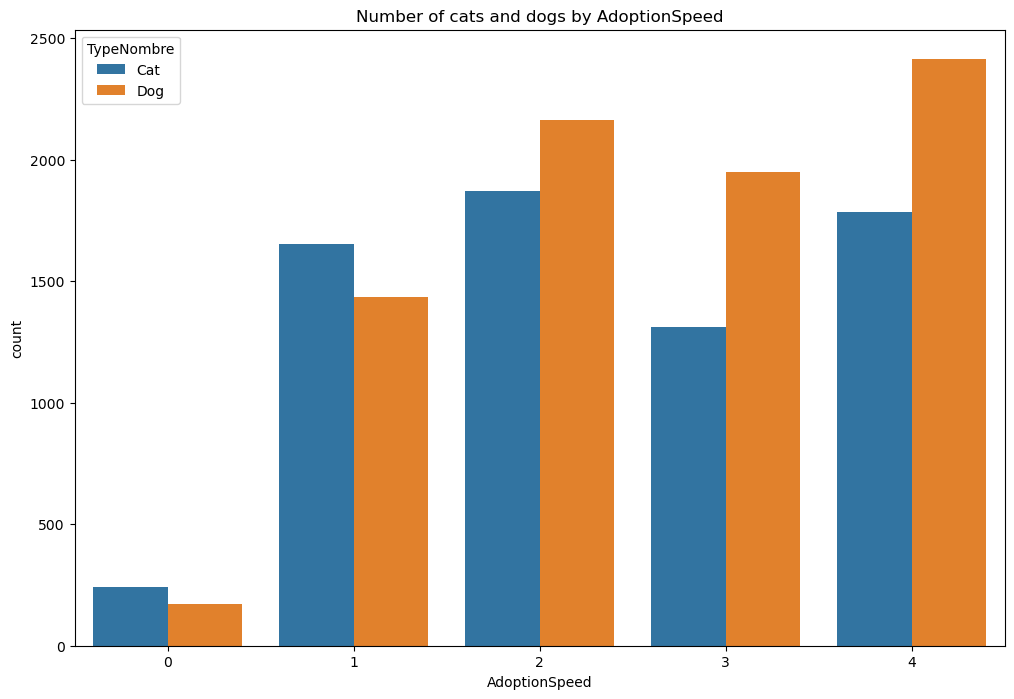

In [52]:
sns.countplot(x='AdoptionSpeed', data=df, hue='TypeNombre')
plt.title('Number of cats and dogs by AdoptionSpeed')

¿Hay alguna diferencia en la rapidez con la que se adoptan los gatos y los perros?

<Figure size 300x300 with 0 Axes>

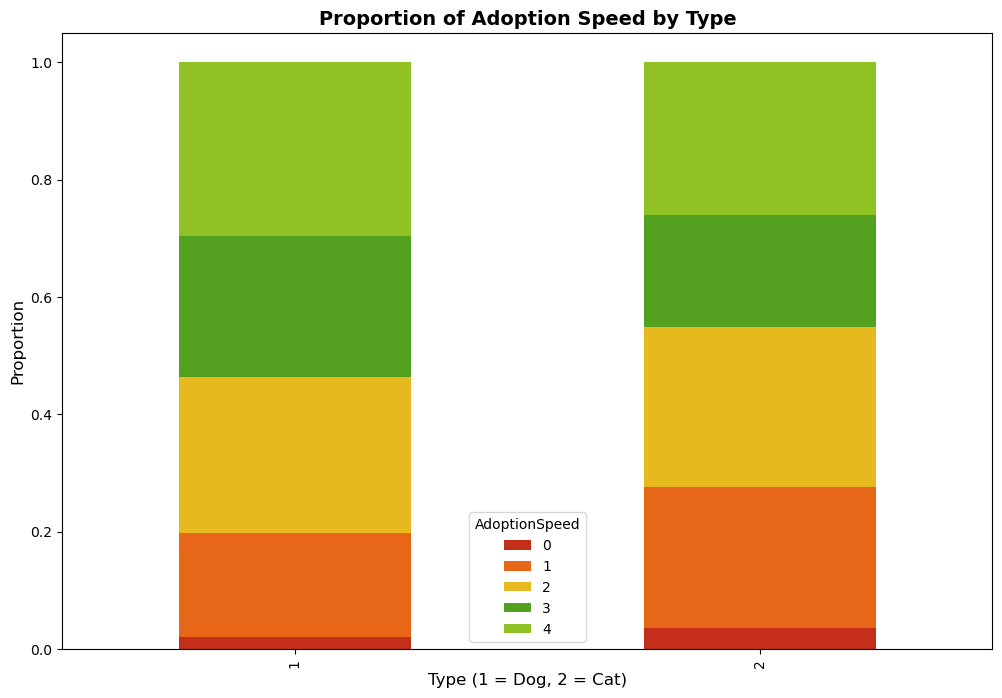

In [53]:
# Filtrar los registros donde 'AdoptionSpeed' no sea NA
filtered_data = df[~df['AdoptionSpeed'].isna()]

# Obtener la cantidad de registros para cada combinación de 'Type' y 'AdoptionSpeed'
count_data = filtered_data.groupby(['Type', 'AdoptionSpeed']).size().unstack()

# Normalizar los valores para que representen la proporción
normalized_data = count_data.div(count_data.sum(axis=1), axis=0)

# Definir los colores personalizados
colors = ['#C42F1A', '#E76618', '#E6B91E', '#54A021', '#90C226']

# Crear un gráfico de barras apiladas con colores personalizados
plt.figure(figsize=(3, 3))
normalized_data.plot(kind='bar', stacked=True, color=colors)

# Establecer etiquetas y títulos
plt.xlabel('Type (1 = Dog, 2 = Cat)', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.title('Proportion of Adoption Speed by Type', fontsize=14, fontweight='bold')

# Mostrar el gráfico
plt.show()

Los gatos parecen haber sido adoptados a un ritmo más rápido que los perros, especialmente, en los niveles 0 y 1.

### 3.4 Distribución del dataset según Gatos y Perros

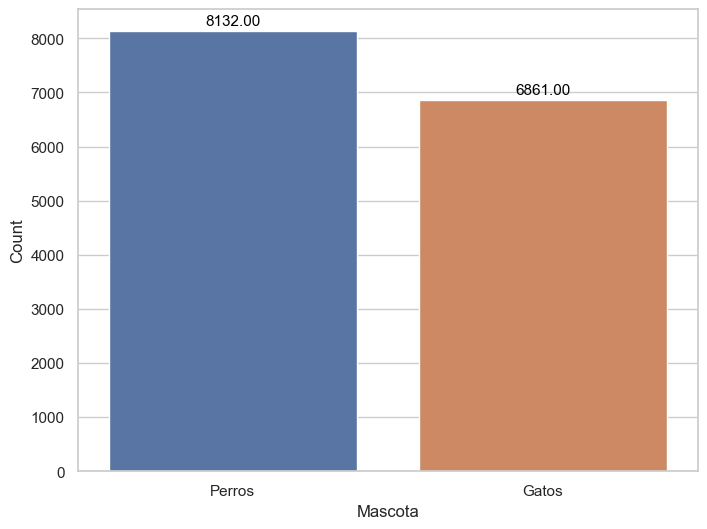

In [58]:
# Establecer el tema de Seaborn
sns.set_theme(style="whitegrid")

# Crear una figura y ajustar el tamaño
plt.figure(figsize=(8, 6))  # Cambia el tamaño de la figura según tus necesidades

# Crear el gráfico de barras
ax = sns.countplot(x="Type", data=df)

# Establecer etiquetas
ax.set(xlabel='Mascota', ylabel='Count')
ax.set_xticklabels(["Perros", "Gatos"])

# Añadir anotaciones a las barras
for i, p in enumerate(ax.patches):
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height() - 80),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 10),
                textcoords='offset points')

# Mostrar el gráfico
plt.show()

Podemos ver que tenemos 8132 perros y 6861 gatos en el dataset, el 54% de las mascotas del conjunto de datos son perros, por lo que el dataset train esta bastante balanceado entre perros y gatos.

### 3.5 Análisis de las razas de las mascotas

Dividimos el dataset en perros y gatos

In [59]:
dogs = df[df['Type'] == 1].copy()
cats = df[df['Type'] == 2].copy()

Perros según raza

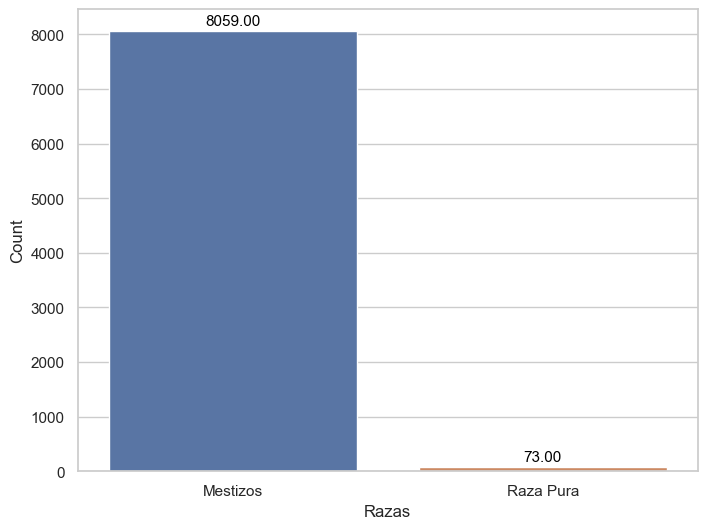

In [66]:
# Establecer el tema de Seaborn
sns.set_theme(style="whitegrid")

# Crear una figura y ajustar el tamaño
plt.figure(figsize=(8, 6))  # Cambia el tamaño de la figura según tus necesidades

# Crear el gráfico de barras
ax = sns.countplot(x="tipo_raza", data=dogs)

# Establecer etiquetas
ax.set(xlabel='Razas', ylabel='Count')
ax.set_xticklabels(["Mestizos", "Raza Pura"])

# Añadir anotaciones a las barras
for i, p in enumerate(ax.patches):
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height() - 80),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 10),
                textcoords='offset points')

# Mostrar el gráfico
plt.show()

Razas de perros vs velocidad de adopción

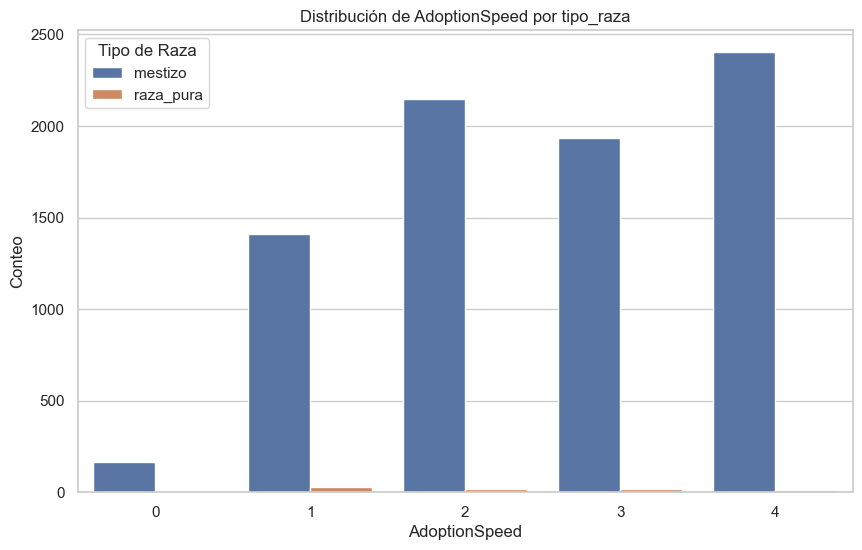

In [70]:
plt.figure(figsize=(10, 6))
sns.countplot(data=dogs, x='AdoptionSpeed', hue='tipo_raza')
plt.title('Distribución de AdoptionSpeed por tipo_raza')
plt.xlabel('AdoptionSpeed')
plt.ylabel('Conteo')
plt.legend(title='Tipo de Raza')
plt.show()

Velocidad de adopción según razas de perros

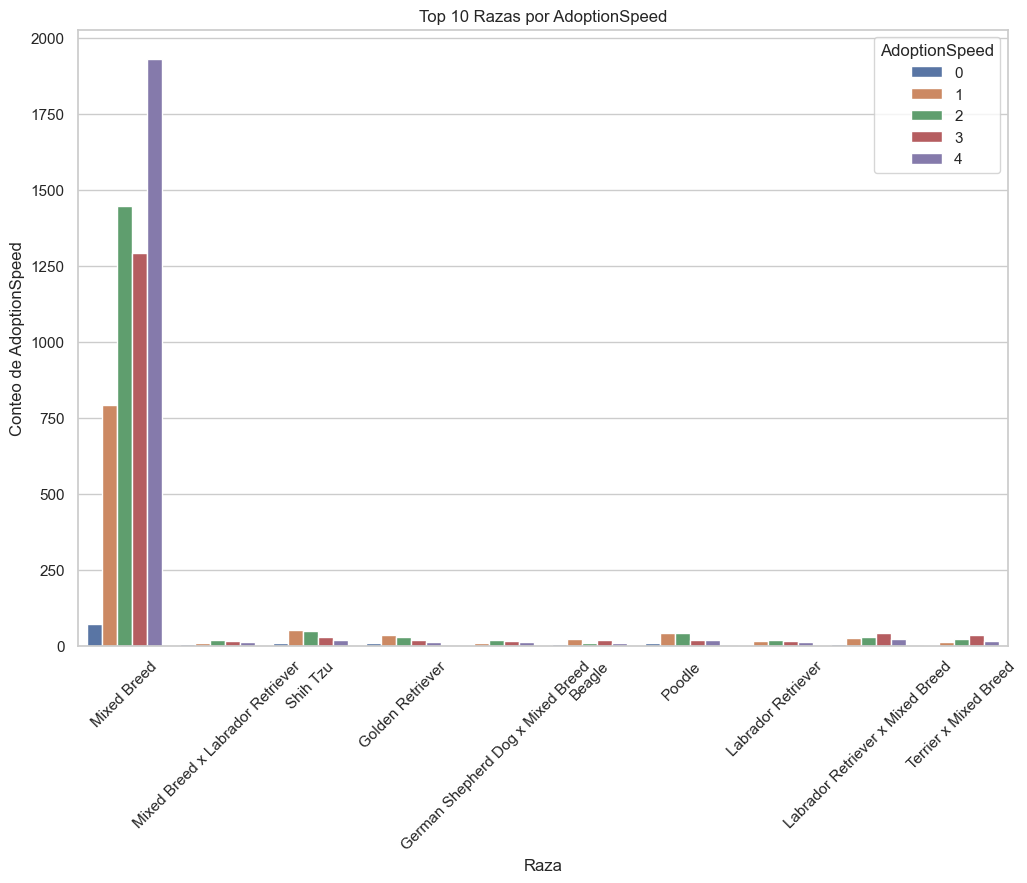

In [73]:
# Agrupar los datos por raza y contar las adopciones
top_razas = dogs['raza'].value_counts().nlargest(10).index
top_df = dogs[dogs['raza'].isin(top_razas)]

# Crear el gráfico de barras
plt.figure(figsize=(12, 8))
sns.countplot(data=top_df, x='raza', hue='AdoptionSpeed')
plt.title('Top 10 Razas por AdoptionSpeed')
plt.xlabel('Raza')
plt.ylabel('Conteo de AdoptionSpeed')
plt.xticks(rotation=45)
plt.legend(title='AdoptionSpeed')
plt.show()


Velocidad de adopción según razas puras de perros

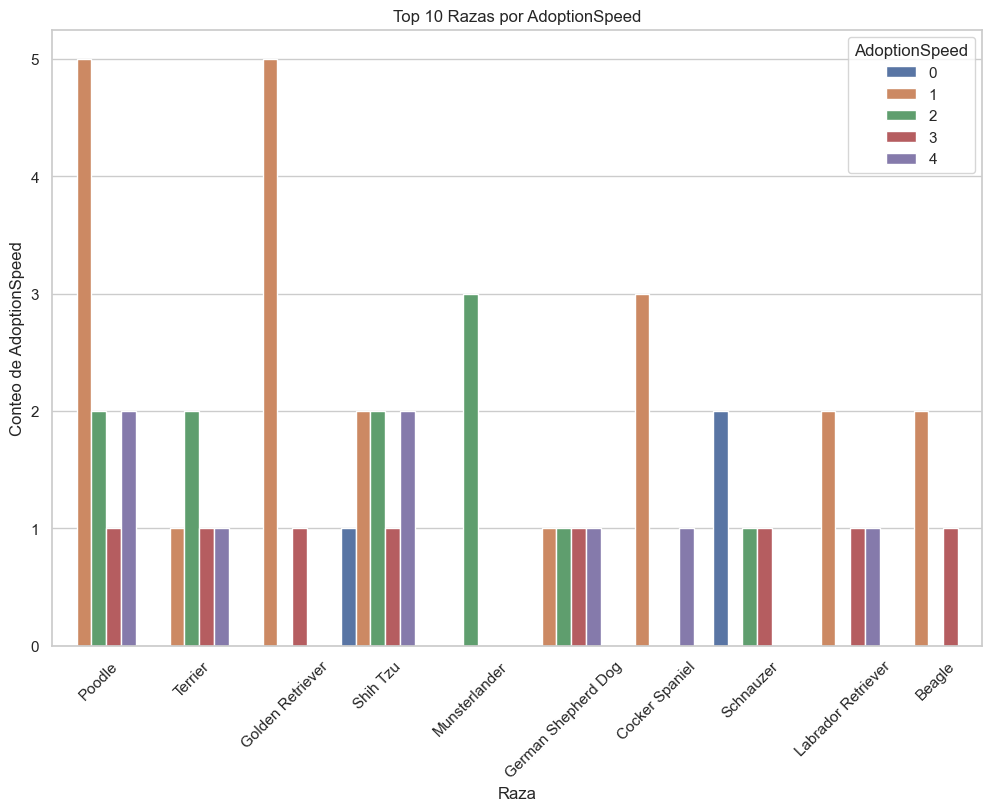

In [75]:
# Agrupar los datos por raza y contar las adopciones
razas_puras = dogs[dogs['tipo_raza'] == 'raza_pura']
top_razas = razas_puras['raza'].value_counts().nlargest(10).index
top_df = razas_puras[razas_puras['raza'].isin(top_razas)]

# Crear el gráfico de barras
plt.figure(figsize=(12, 8))
sns.countplot(data=top_df, x='raza', hue='AdoptionSpeed')
plt.title('Top 10 Razas por AdoptionSpeed')
plt.xlabel('Raza')
plt.ylabel('Conteo de AdoptionSpeed')
plt.xticks(rotation=45)
plt.legend(title='AdoptionSpeed')
plt.show()

Gatos según raza

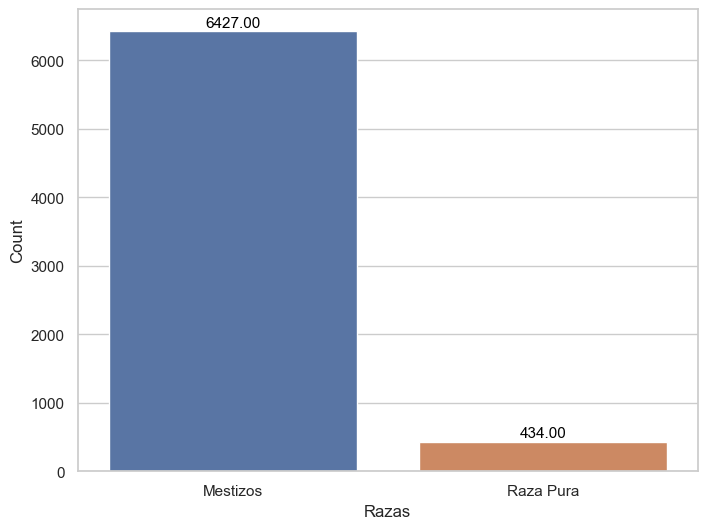

In [67]:
# Establecer el tema de Seaborn
sns.set_theme(style="whitegrid")

# Crear una figura y ajustar el tamaño
plt.figure(figsize=(8, 6))  # Cambia el tamaño de la figura según tus necesidades

# Crear el gráfico de barras
ax = sns.countplot(x="tipo_raza", data=cats)

# Establecer etiquetas
ax.set(xlabel='Razas', ylabel='Count')
ax.set_xticklabels(["Mestizos", "Raza Pura"])

# Añadir anotaciones a las barras
for i, p in enumerate(ax.patches):
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height() - 80),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 10),
                textcoords='offset points')

# Mostrar el gráfico
plt.show()

Gatos según velocidad de adopción

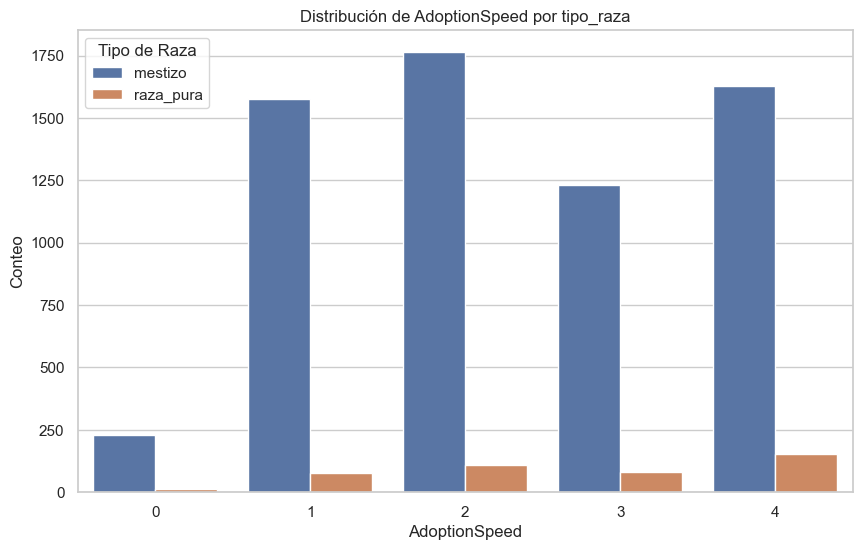

In [71]:
plt.figure(figsize=(10, 6))
sns.countplot(data=cats, x='AdoptionSpeed', hue='tipo_raza')
plt.title('Distribución de AdoptionSpeed por tipo_raza')
plt.xlabel('AdoptionSpeed')
plt.ylabel('Conteo')
plt.legend(title='Tipo de Raza')
plt.show()

Velocidad de adopción según razas de gatos

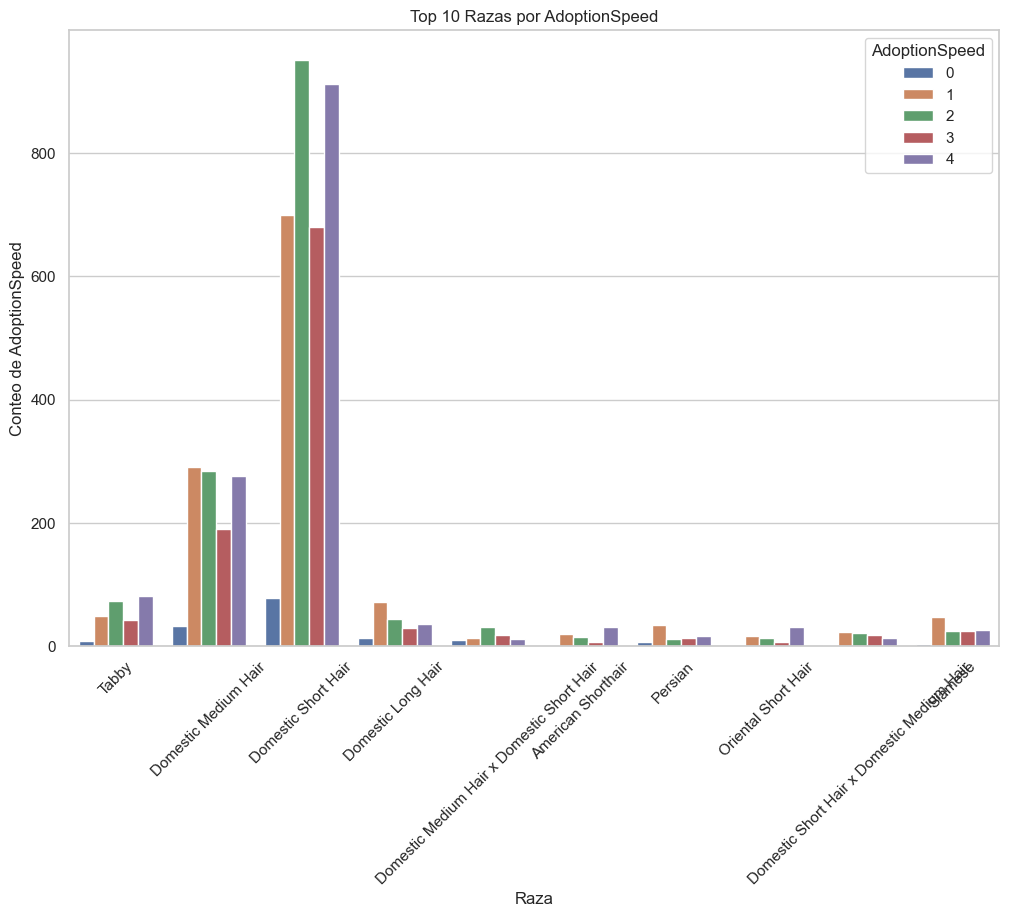

In [74]:
# Agrupar los datos por raza y contar las adopciones
top_razas = cats['raza'].value_counts().nlargest(10).index
top_df = cats[cats['raza'].isin(top_razas)]

# Crear el gráfico de barras
plt.figure(figsize=(12, 8))
sns.countplot(data=top_df, x='raza', hue='AdoptionSpeed')
plt.title('Top 10 Razas por AdoptionSpeed')
plt.xlabel('Raza')
plt.ylabel('Conteo de AdoptionSpeed')
plt.xticks(rotation=45)
plt.legend(title='AdoptionSpeed')
plt.show()

Velocidad de adopción según razas puras de gatos

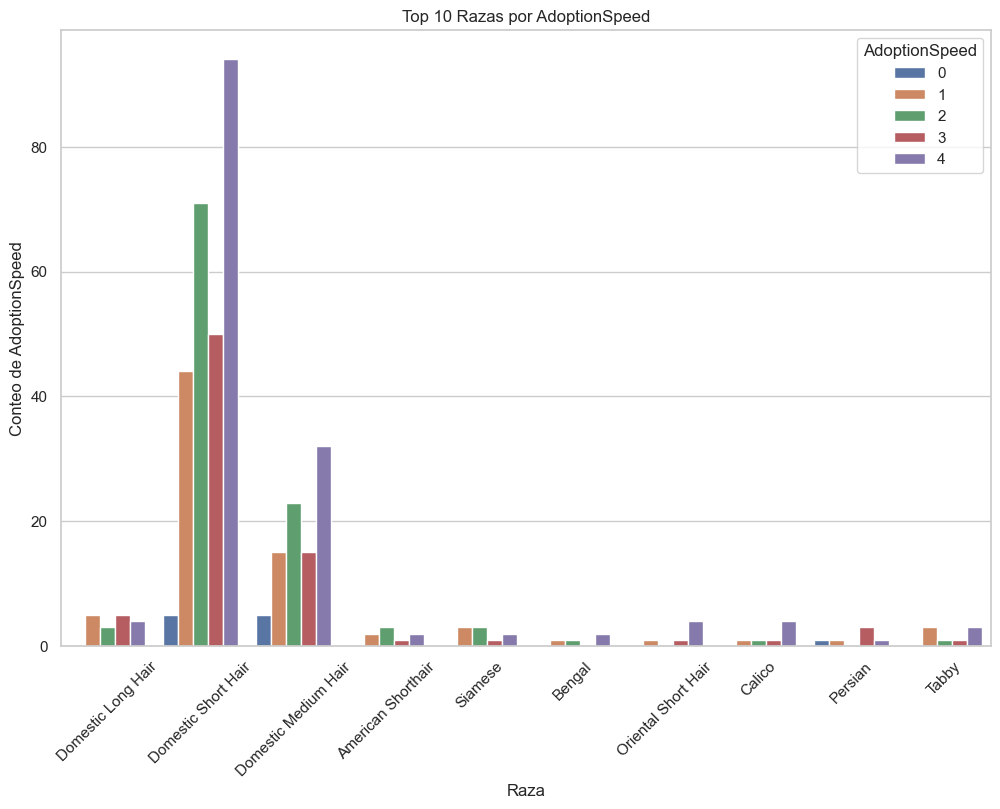

In [76]:
# Agrupar los datos por raza y contar las adopciones
razas_puras = cats[cats['tipo_raza'] == 'raza_pura']
top_razas = razas_puras['raza'].value_counts().nlargest(10).index
top_df = razas_puras[razas_puras['raza'].isin(top_razas)]

# Crear el gráfico de barras
plt.figure(figsize=(12, 8))
sns.countplot(data=top_df, x='raza', hue='AdoptionSpeed')
plt.title('Top 10 Razas por AdoptionSpeed')
plt.xlabel('Raza')
plt.ylabel('Conteo de AdoptionSpeed')
plt.xticks(rotation=45)
plt.legend(title='AdoptionSpeed')
plt.show()

### 3.6 Velocidad de Adopción según el género

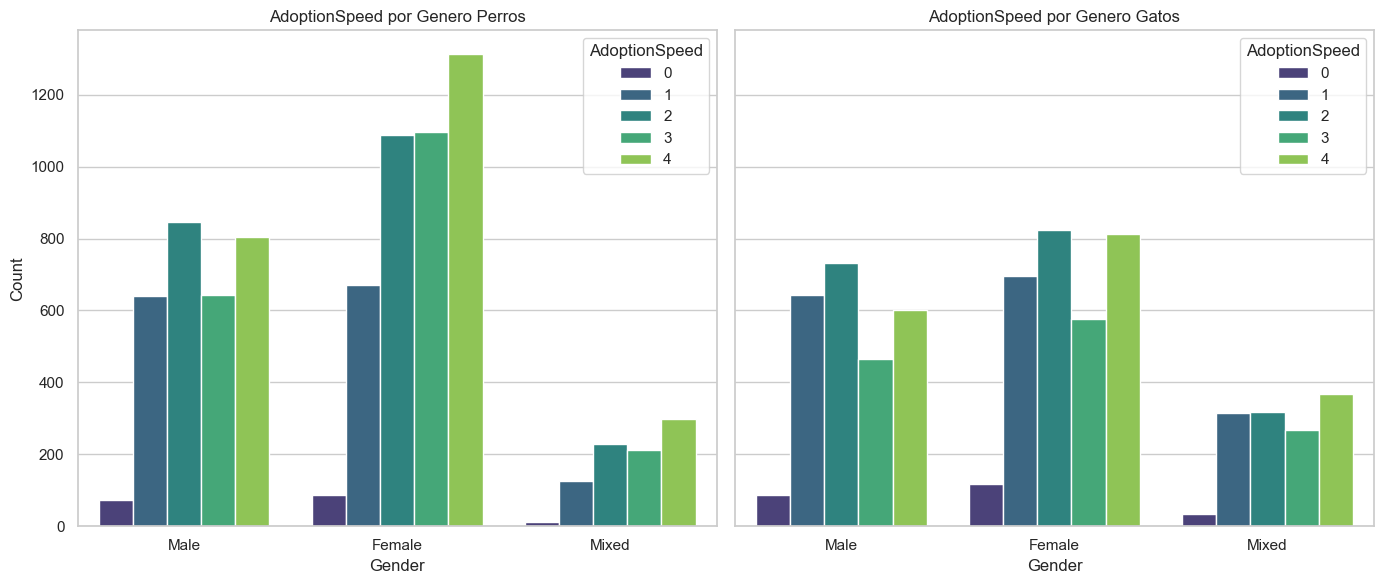

In [72]:
# Crear las figuras y ejes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharey=True)

# Gráfico de barras para los perros
sns.countplot(ax=axes[0], x='Gender', hue='AdoptionSpeed', data=dogs, palette='viridis')
axes[0].set_title('AdoptionSpeed por Genero Perros')
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Male', 'Female', 'Mixed'])
axes[0].legend(title='AdoptionSpeed')

# Gráfico de barras para los gatos
sns.countplot(ax=axes[1], x='Gender', hue='AdoptionSpeed', data=cats, palette='viridis')
axes[1].set_title('AdoptionSpeed por Genero Gatos')
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Male', 'Female', 'Mixed'])
axes[1].legend(title='AdoptionSpeed')

# Mostrar los gráficos
plt.tight_layout()
plt.show()

Viendo en el gráfico que las hembras, tanto en gatos como en perros, tienen mayor tendencia a ser adoptados.

### 3.7 Análisis de los colores de las mascotas

Creamos una nueva columna con los 3 colores de la mascota

In [83]:
# Crear una columna para representar la combinación de colores
df['Colors'] = df.apply(lambda x: f"{x['Color1Nombre']}_{x['Color2Nombre']}_{x['Color3Nombre']}", axis=1)
df['Colors'] = df['Colors'].str.replace('_None_None', '', case=False)
df['Colors'] = df['Colors'].str.replace('_None', '', case=False)

# Mostrar algunas filas para ver la nueva columna
print(df[['Color1Nombre', 'Color2Nombre', 'Color3Nombre', 'Colors']].head())

  Color1Nombre Color2Nombre Color3Nombre       Colors
0        Black        White         None  Black_White
1        Black        Brown         None  Black_Brown
2        Brown        White         None  Brown_White
3        Black        Brown         None  Black_Brown
4        Black         None         None        Black


Dividimos nuevamente en gatos y perros

In [84]:
dogs = df[df['Type'] == 1].copy()
cats = df[df['Type'] == 2].copy()

Colores en Perros

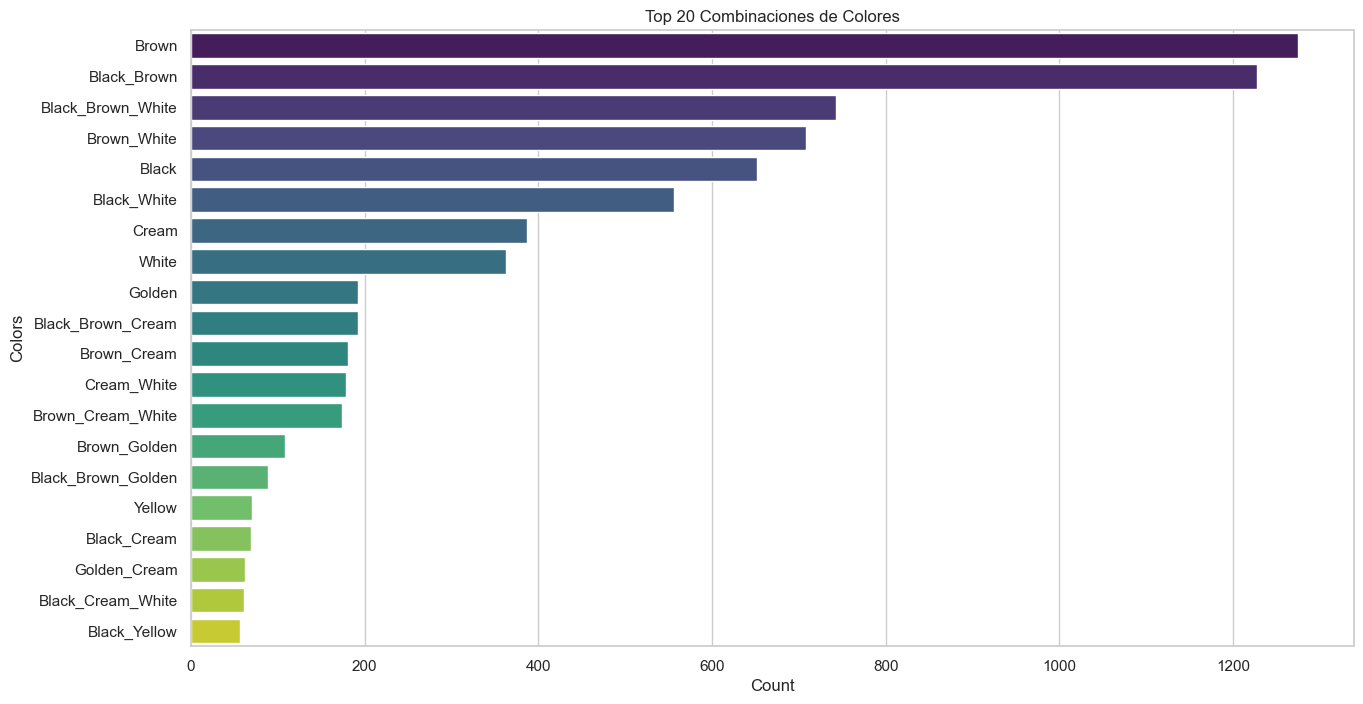

In [85]:
# Contar la frecuencia de cada combinación de colores
colores = dogs.copy()
color_counts = colores['Colors'].value_counts().reset_index()
color_counts.columns = ['Colors', 'Count']

# Graficar la distribución de combinaciones de colores
plt.figure(figsize=(15, 8))
sns.barplot(x='Count', y='Colors', data=color_counts.head(20), palette='viridis')
plt.title('Top 20 Combinaciones de Colores')
plt.show()

Adopción según el color en perros

     AdoptionSpeed             Colors  Count
13               0              Brown     31
5                0  Black_Brown_White     24
20               0        Brown_White     13
1                0        Black_Brown     12
23               0              Cream     11
26               0             Golden      9
0                0              Black      8
25               0        Cream_White      7
32               0              White      7
12               0        Black_White      6
34               1        Black_Brown    207
51               1              Brown    203
38               1  Black_Brown_White    125
61               1        Brown_White    115
48               1        Black_White    109
33               1              Black    101
65               1              Cream     86
77               1              White     85
68               1        Cream_White     39
69               1             Golden     35
84               2        Black_Brown    375
102       

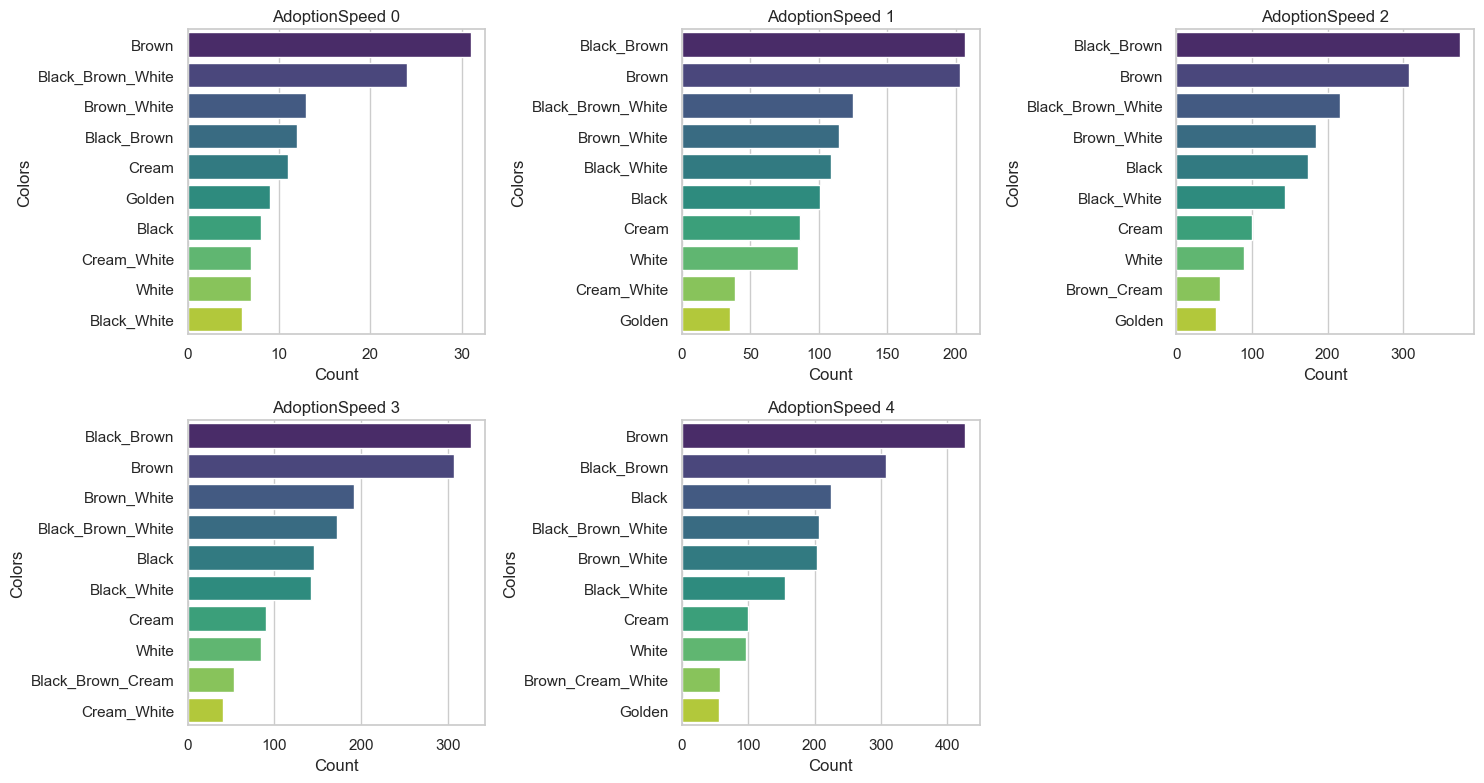

In [88]:
# Contar la frecuencia de cada combinación de colores para cada velocidad de adopción
color_adoption_counts = dogs.groupby(['AdoptionSpeed', 'Colors']).size().reset_index(name='Count')


# Crear una lista para almacenar los resultados del top 10 por cada AdoptionSpeed
top_10_colors_per_speed = []

# Iterar sobre cada valor único de AdoptionSpeed y obtener el top 10
for speed in color_adoption_counts['AdoptionSpeed'].unique():
    top_colors = color_adoption_counts[color_adoption_counts['AdoptionSpeed'] == speed]
    top_10_colors = top_colors.sort_values(by='Count', ascending=False).head(10)
    top_10_colors_per_speed.append(top_10_colors)

# Concatenar todos los top 10 en un solo DataFrame
top_10_colors_per_speed_df = pd.concat(top_10_colors_per_speed)

# Mostrar el resultado
print(top_10_colors_per_speed_df)

# Configuración de la figura
plt.figure(figsize=(15, 8))

# Iterar sobre cada velocidad de adopción para crear subplots
for i, speed in enumerate(color_adoption_counts['AdoptionSpeed'].unique()):
    plt.subplot(2, 3, i + 1)
    top_colors = top_10_colors_per_speed_df[top_10_colors_per_speed_df['AdoptionSpeed'] == speed]
    sns.barplot(x='Count', y='Colors', data=top_colors, palette='viridis')
    plt.title(f'AdoptionSpeed {speed}')

plt.tight_layout()
plt.show()

Colores en gatos

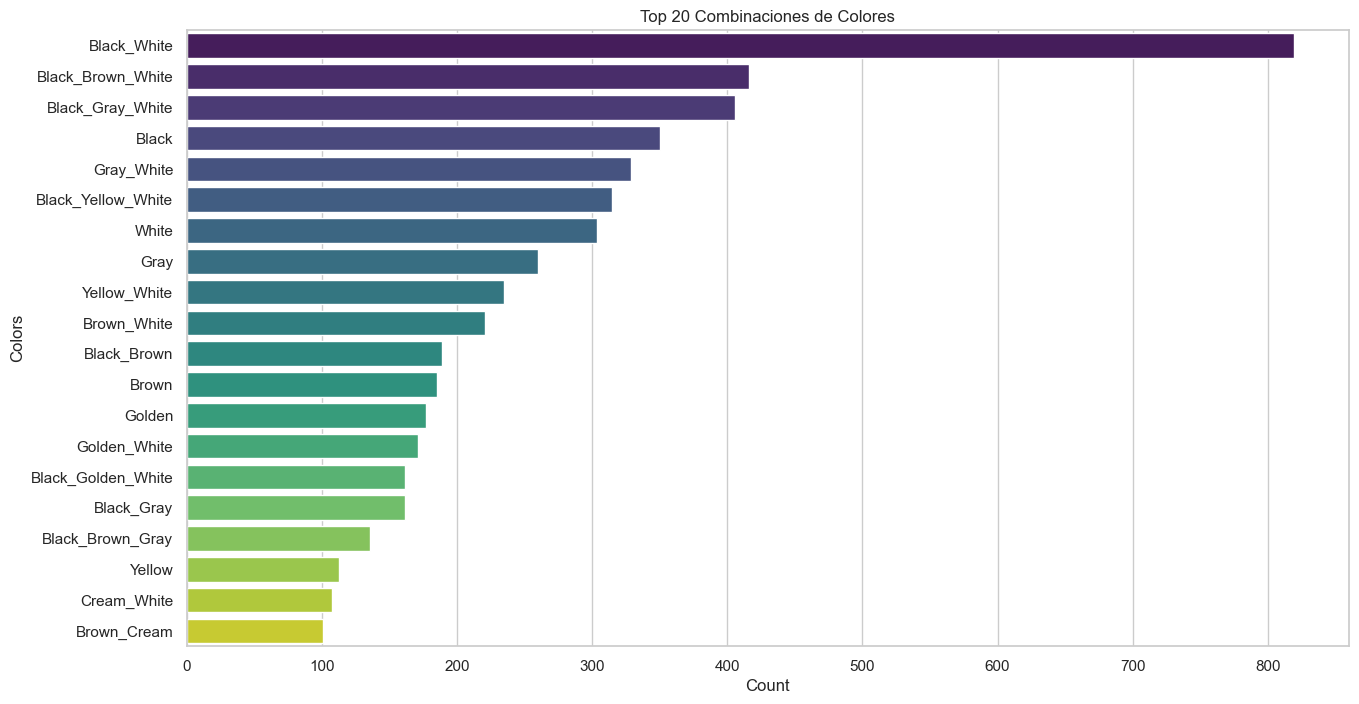

In [86]:
# Contar la frecuencia de cada combinación de colores
colores = cats.copy()
color_counts = colores['Colors'].value_counts().reset_index()
color_counts.columns = ['Colors', 'Count']

# Graficar la distribución de combinaciones de colores
plt.figure(figsize=(15, 8))
sns.barplot(x='Count', y='Colors', data=color_counts.head(20), palette='viridis')
plt.title('Top 20 Combinaciones de Colores')
plt.show()

Adopción según el color en gatos

     AdoptionSpeed              Colors  Count
13               0         Black_White     28
42               0          Gray_White     18
5                0   Black_Brown_White     15
12               0    Black_Gray_White     14
26               0         Brown_White     14
21               0   Brown_Cream_White     10
18               0               Brown     10
41               0                Gray      9
19               0         Brown_Cream      9
1                0         Black_Brown      7
67               1         Black_White    191
66               1    Black_Gray_White    116
105              1               White     91
55               1   Black_Brown_White     85
104              1          Gray_White     82
50               1               Black     81
111              1        Yellow_White     60
72               1               Brown     56
83               1         Brown_White     54
103              1                Gray     53
129              2         Black_W

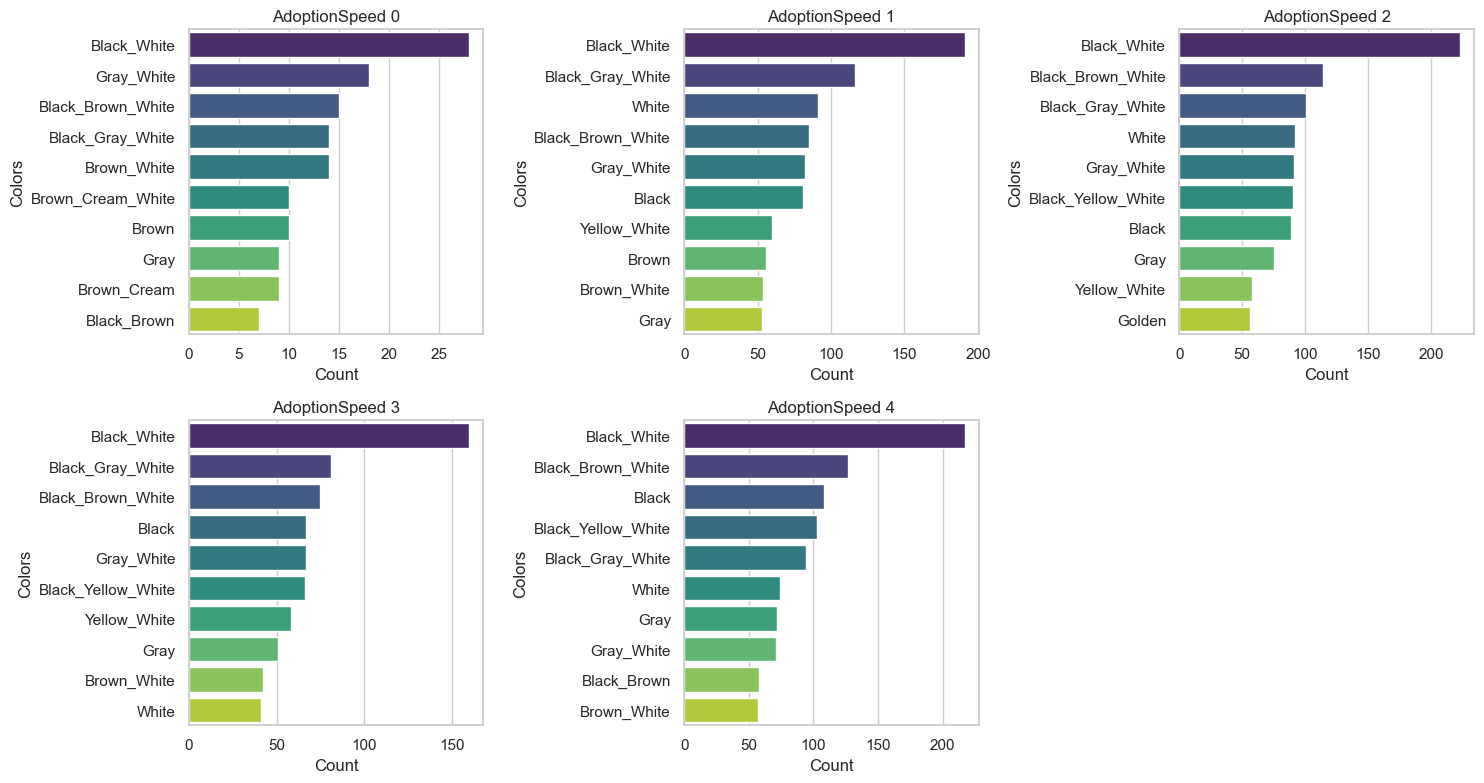

In [87]:
# Contar la frecuencia de cada combinación de colores para cada velocidad de adopción
color_adoption_counts = cats.groupby(['AdoptionSpeed', 'Colors']).size().reset_index(name='Count')


# Crear una lista para almacenar los resultados del top 10 por cada AdoptionSpeed
top_10_colors_per_speed = []

# Iterar sobre cada valor único de AdoptionSpeed y obtener el top 10
for speed in color_adoption_counts['AdoptionSpeed'].unique():
    top_colors = color_adoption_counts[color_adoption_counts['AdoptionSpeed'] == speed]
    top_10_colors = top_colors.sort_values(by='Count', ascending=False).head(10)
    top_10_colors_per_speed.append(top_10_colors)

# Concatenar todos los top 10 en un solo DataFrame
top_10_colors_per_speed_df = pd.concat(top_10_colors_per_speed)

# Mostrar el resultado
print(top_10_colors_per_speed_df)

# Configuración de la figura
plt.figure(figsize=(15, 8))

# Iterar sobre cada velocidad de adopción para crear subplots
for i, speed in enumerate(color_adoption_counts['AdoptionSpeed'].unique()):
    plt.subplot(2, 3, i + 1)
    top_colors = top_10_colors_per_speed_df[top_10_colors_per_speed_df['AdoptionSpeed'] == speed]
    sns.barplot(x='Count', y='Colors', data=top_colors, palette='viridis')
    plt.title(f'AdoptionSpeed {speed}')

plt.tight_layout()
plt.show()

### 3.8 Análisis de la Salud de la mascota

Perros

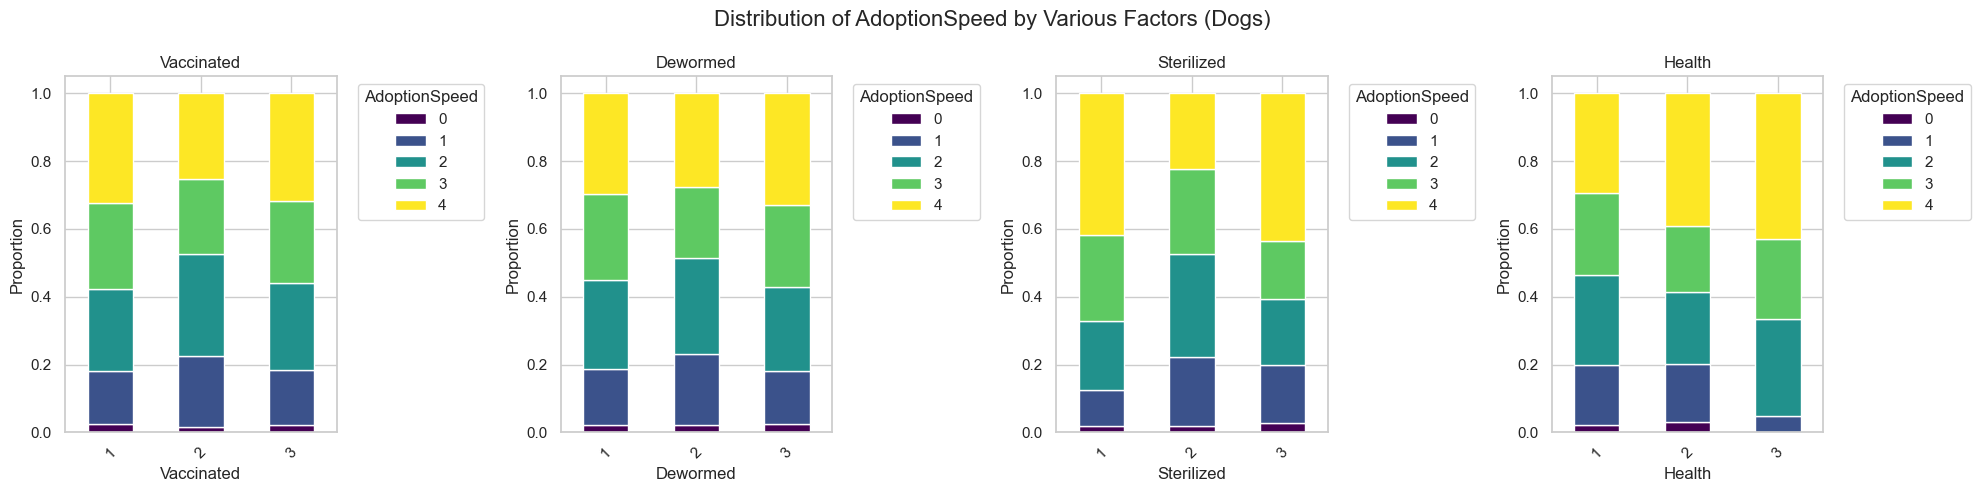

In [89]:
def stacked_bar_plot(df, columns, title):
    # Crear una figura con subplots en una fila
    fig, axes = plt.subplots(1, len(columns), figsize=(20, 5))
    fig.suptitle(title, fontsize=16)

    for i, column in enumerate(columns):
        # Calcular la distribución de AdoptionSpeed dentro de cada categoría
        distribution = df.groupby([column, 'AdoptionSpeed']).size().unstack(fill_value=0)
        distribution_norm = distribution.div(distribution.sum(axis=1), axis=0)

        # Graficar en el subplot correspondiente
        distribution_norm.plot(kind='bar', stacked=True, ax=axes[i], colormap='viridis')
        axes[i].set_title(f'{column}')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Proportion')
        axes[i].legend(title='AdoptionSpeed', bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Rotar las etiquetas del eje x para mejor legibilidad
        axes[i].tick_params(axis='x', rotation=45)

    # Ajustar el espaciado entre subplots
    plt.tight_layout()
    plt.show()

# Gráficos para perros
columns = ['Vaccinated', 'Dewormed', 'Sterilized', 'Health']
stacked_bar_plot(dogs, columns, 'Distribution of AdoptionSpeed by Various Factors (Dogs)')

Gatos

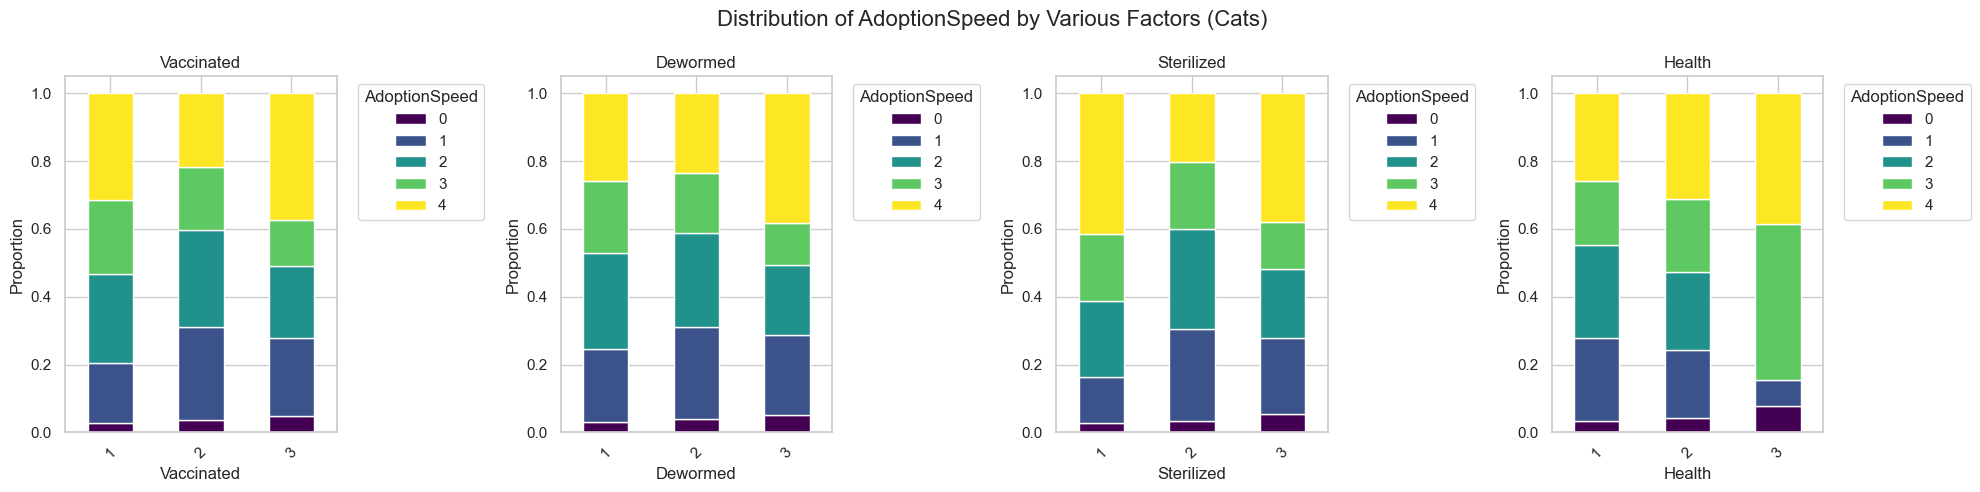

In [90]:
# Gráficos para perros
columns = ['Vaccinated', 'Dewormed', 'Sterilized', 'Health']
stacked_bar_plot(cats, columns, 'Distribution of AdoptionSpeed by Various Factors (Cats)')

### 3.9 Impacto del Fee cobrado

Distribución del Fee a nivel general y discriminado por perros y gatos

c:\Users\Usuario\.conda\envs\ldi2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Usuario\.conda\envs\ldi2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Usuario\.conda\envs\ldi2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


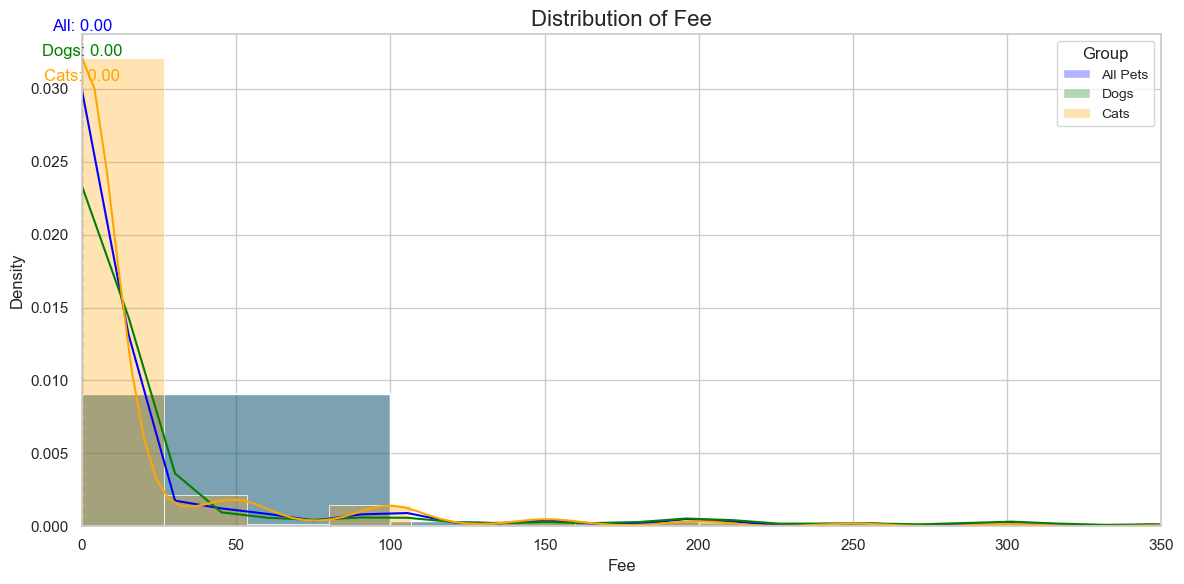

In [97]:
# Configurar el estilo de seaborn
sns.set_style("whitegrid")

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(12, 6))

# Definir un límite superior para el eje x (por ejemplo, el percentil 99)
upper_limit = np.percentile(df['Fee'], 99)

# Gráfico de histograma para todos los datos
sns.histplot(df['Fee'], bins=30, kde=True, color='blue', alpha=0.3, label='All Pets', ax=ax, stat='density')

# Gráfico de histograma para perros
sns.histplot(dogs['Fee'], bins=30, kde=True, color='green', alpha=0.3, label='Dogs', ax=ax, stat='density')

# Gráfico de histograma para gatos
sns.histplot(cats['Fee'], bins=30, kde=True, color='orange', alpha=0.3, label='Cats', ax=ax, stat='density')

# Añadir título y etiquetas de los ejes
ax.set_title('Distribution of Fee', fontsize=16)
ax.set_xlabel('Fee', fontsize=12)
ax.set_ylabel('Density', fontsize=12)

# Ajustar el rango del eje x
ax.set_xlim(0, upper_limit)

# Añadir una leyenda
ax.legend(title='Group', title_fontsize='12', fontsize='10')

# Añadir líneas verticales para las medianas
ax.axvline(df['Fee'].median(), color='blue', linestyle='--', label='All Pets Median')
ax.axvline(dogs['Fee'].median(), color='green', linestyle='--', label='Dogs Median')
ax.axvline(cats['Fee'].median(), color='orange', linestyle='--', label='Cats Median')

# Añadir anotaciones para las medianas
ax.text(df['Fee'].median(), ax.get_ylim()[1], f'All: {df["Fee"].median():.2f}', 
        horizontalalignment='center', verticalalignment='bottom', color='blue')
ax.text(dogs['Fee'].median(), ax.get_ylim()[1]*0.95, f'Dogs: {dogs["Fee"].median():.2f}', 
        horizontalalignment='center', verticalalignment='bottom', color='green')
ax.text(cats['Fee'].median(), ax.get_ylim()[1]*0.90, f'Cats: {cats["Fee"].median():.2f}', 
        horizontalalignment='center', verticalalignment='bottom', color='orange')

# Ajustar el espaciado
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Velocidad de adopción a nivel general en función de Fee (Gratis, Pago)

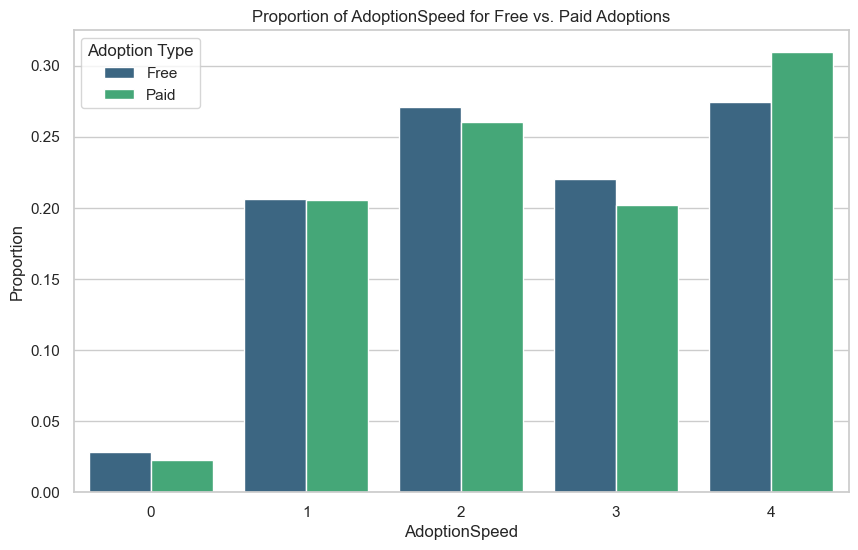

In [92]:
# Crear una columna para indicar si la adopción fue gratuita o pagada
df['AdoptionType'] = df['Fee'].apply(lambda x: 'Free' if x == 0 else 'Paid')

# Calcular la proporción de cada AdoptionSpeed para adopciones gratuitas y pagadas
adoption_counts = df.groupby(['AdoptionType', 'AdoptionSpeed']).size().unstack(fill_value=0)
adoption_proportions = adoption_counts.div(adoption_counts.sum(axis=1), axis=0)
adoption_proportions.reset_index(inplace=True)


# Transformar los datos para el gráfico
adoption_proportions_melted = adoption_proportions.melt(id_vars='AdoptionType', var_name='AdoptionSpeed', value_name='Proportion')

# Graficar las proporciones de AdoptionSpeed para adopciones gratuitas y pagadas
plt.figure(figsize=(10, 6))
sns.barplot(x='AdoptionSpeed', y='Proportion', hue='AdoptionType', data=adoption_proportions_melted, palette='viridis')
plt.title('Proportion of AdoptionSpeed for Free vs. Paid Adoptions')
plt.xlabel('AdoptionSpeed')
plt.ylabel('Proportion')
plt.legend(title='Adoption Type')
plt.show()

Velocidad de adopción de perros y gatos en función de Fee (Gratis, Pago)

In [104]:
dogs = df[df['Type'] == 1].copy()
cats = df[df['Type'] == 2].copy()

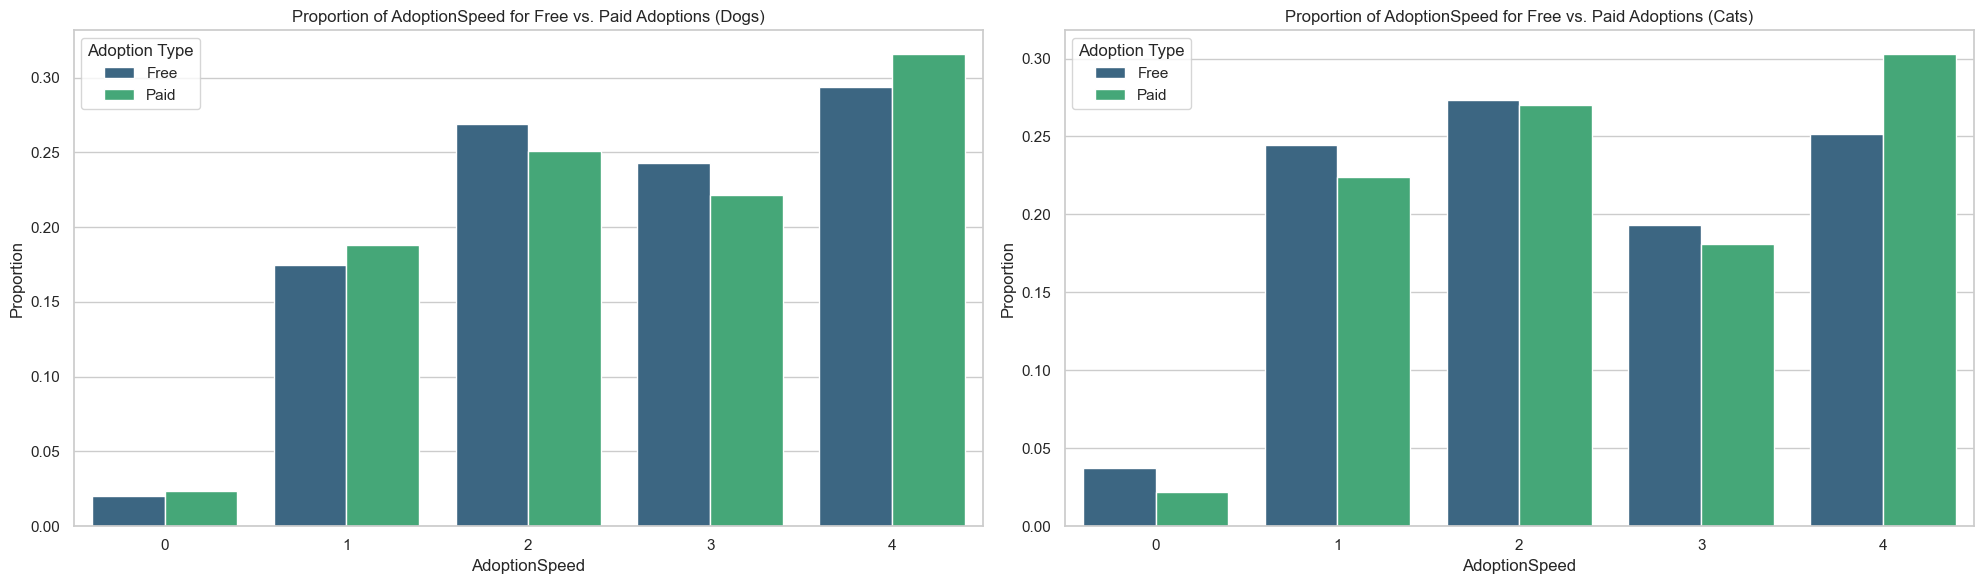

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular la proporción de cada AdoptionSpeed para adopciones gratuitas y pagadas para perros
adoption_counts_dogs = dogs.groupby(['AdoptionType', 'AdoptionSpeed']).size().unstack(fill_value=0)
adoption_proportions_dogs = adoption_counts_dogs.div(adoption_counts_dogs.sum(axis=1), axis=0)
adoption_proportions_dogs.reset_index(inplace=True)

# Calcular la proporción de cada AdoptionSpeed para adopciones gratuitas y pagadas para gatos
adoption_counts_cats = cats.groupby(['AdoptionType', 'AdoptionSpeed']).size().unstack(fill_value=0)
adoption_proportions_cats = adoption_counts_cats.div(adoption_counts_cats.sum(axis=1), axis=0)
adoption_proportions_cats.reset_index(inplace=True)

# Transformar los datos para los gráficos
adoption_proportions_dogs_melted = adoption_proportions_dogs.melt(id_vars='AdoptionType', var_name='AdoptionSpeed', value_name='Proportion')
adoption_proportions_cats_melted = adoption_proportions_cats.melt(id_vars='AdoptionType', var_name='AdoptionSpeed', value_name='Proportion')

# Crear una figura con dos subplots en una fila
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Graficar las proporciones de AdoptionSpeed para adopciones gratuitas y pagadas para perros
sns.barplot(x='AdoptionSpeed', y='Proportion', hue='AdoptionType', data=adoption_proportions_dogs_melted, palette='viridis', ax=ax1)
ax1.set_title('Proportion of AdoptionSpeed for Free vs. Paid Adoptions (Dogs)')
ax1.set_xlabel('AdoptionSpeed')
ax1.set_ylabel('Proportion')
ax1.legend(title='Adoption Type')

# Graficar las proporciones de AdoptionSpeed para adopciones gratuitas y pagadas para gatos
sns.barplot(x='AdoptionSpeed', y='Proportion', hue='AdoptionType', data=adoption_proportions_cats_melted, palette='viridis', ax=ax2)
ax2.set_title('Proportion of AdoptionSpeed for Free vs. Paid Adoptions (Cats)')
ax2.set_xlabel('AdoptionSpeed')
ax2.set_ylabel('Proportion')
ax2.legend(title='Adoption Type')

# Ajustar el espaciado entre subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

Vemos que los de adopción 0 tanto en perros y en gatos no diferencia entre Fee gratis o pago.

### 3.10 Regiones geográficas

Gráfico de barras de cantidad de adopciones y Regiones geográficas

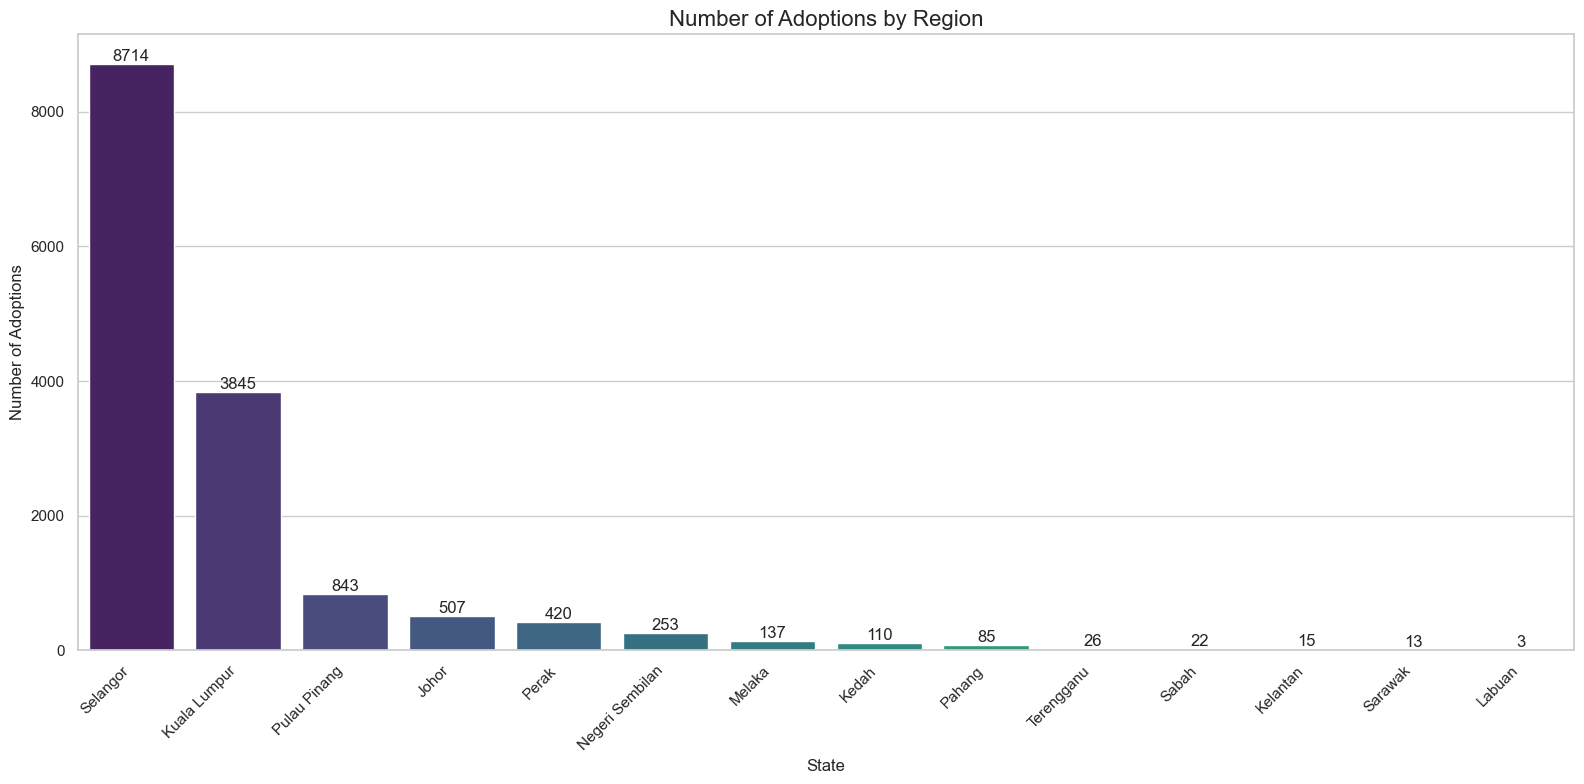

In [102]:
# Obtener el conteo de adopciones por región
state_counts = df['StateName'].value_counts().reset_index()
state_counts.columns = ['StateName', 'Count']

# Crear la figura y los ejes
plt.figure(figsize=(16, 8))

# Graficar el conteo de adopciones por región
ax = sns.barplot(x='StateName', y='Count', data=state_counts, palette='viridis')

# Añadir el valor encima de cada barra
for i, v in enumerate(state_counts['Count']):
    ax.text(i, v, str(v), ha='center', va='bottom')

# Configurar el título y las etiquetas
plt.title('Number of Adoptions by Region', fontsize=16)
plt.xlabel('State', fontsize=12)
plt.ylabel('Number of Adoptions', fontsize=12)

# Rotar las etiquetas del eje x para mejor legibilidad
plt.xticks(rotation=45, ha='right')

# Ajustar el diseño para evitar que se corten las etiquetas
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Gráfico de barras de cantidad de adopciones y Regiones geográficas

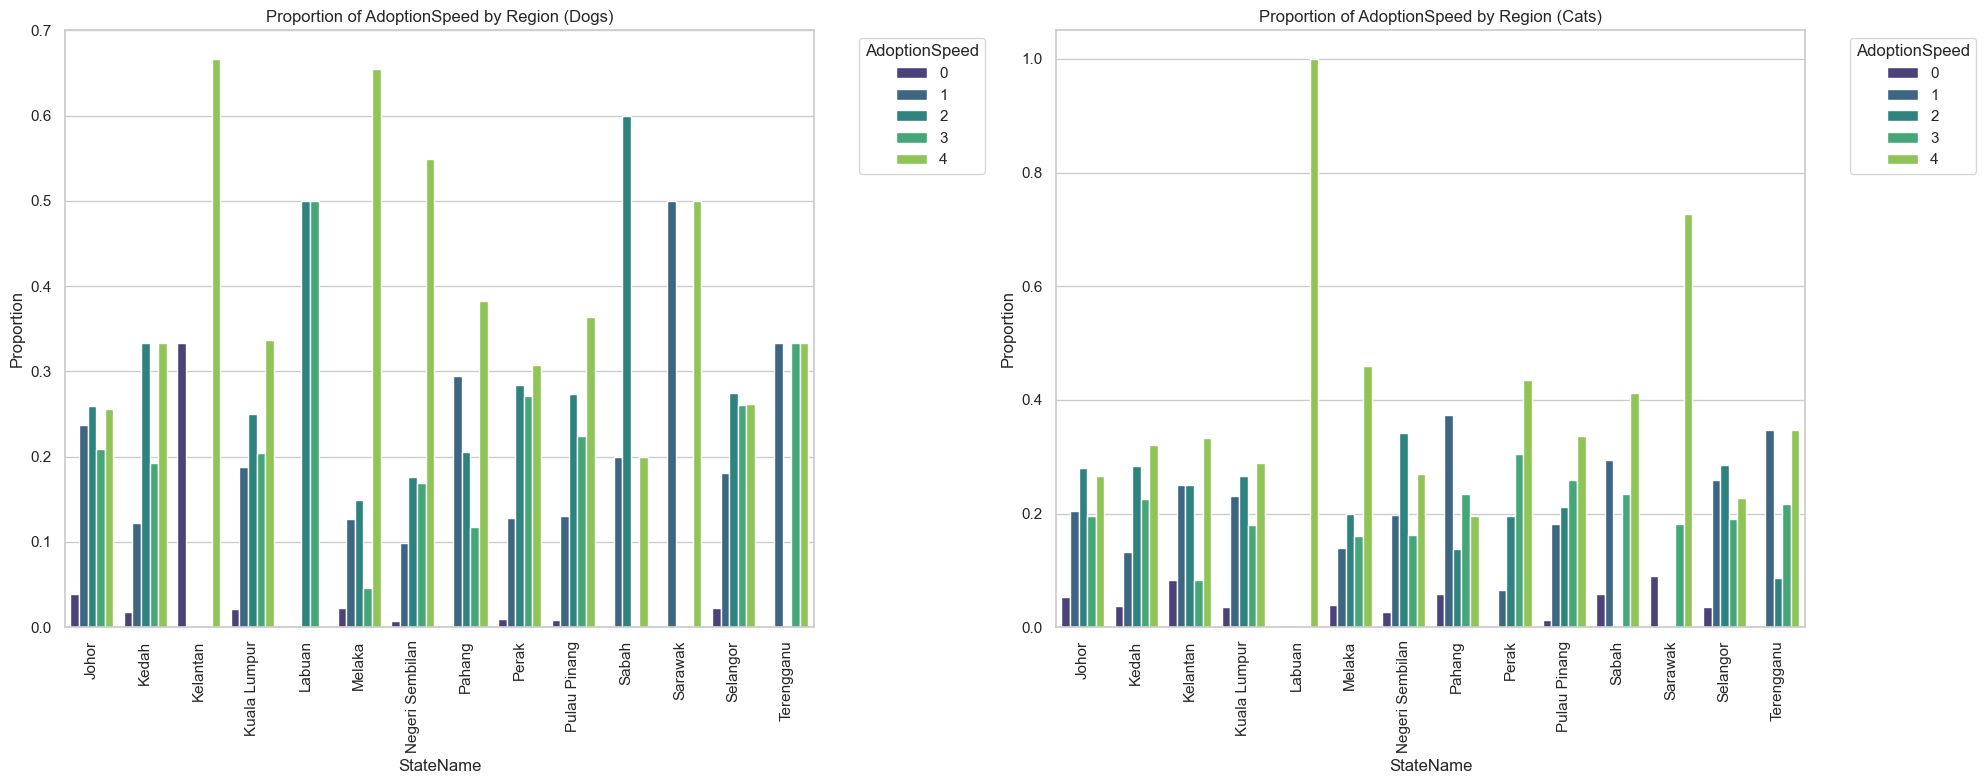

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

# Función para crear el gráfico para un dataframe específico
def create_adoption_speed_plot(df, title):
    # Calcular la proporción de cada AdoptionSpeed por región
    df['AdoptionSpeed_str'] = df['AdoptionSpeed'].astype(str)
    adoption_counts_state = df.groupby(['StateName', 'AdoptionSpeed_str']).size().unstack(fill_value=0)
    adoption_proportions_state = adoption_counts_state.div(adoption_counts_state.sum(axis=1), axis=0)
    adoption_proportions_state.reset_index(inplace=True)

    # Transformar los datos para el gráfico
    adoption_proportions_state_melted = adoption_proportions_state.melt(id_vars='StateName', var_name='AdoptionSpeed_str', value_name='Proportion')

    # Crear el gráfico
    sns.barplot(x='StateName', y='Proportion', hue='AdoptionSpeed_str', data=adoption_proportions_state_melted, palette='viridis')
    plt.title(title)
    plt.xlabel('StateName')
    plt.ylabel('Proportion')
    plt.xticks(rotation=90)
    plt.legend(title='AdoptionSpeed', bbox_to_anchor=(1.05, 1), loc='upper left')

# Crear una figura con dos subplots en una fila
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Gráfico para perros
plt.sca(ax1)
create_adoption_speed_plot(dogs, 'Proportion of AdoptionSpeed by Region (Dogs)')

# Gráfico para gatos
plt.sca(ax2)
create_adoption_speed_plot(cats, 'Proportion of AdoptionSpeed by Region (Cats)')

# Ajustar el espaciado entre subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

### 3.11 Impacto de tener Fotos y/o Videos

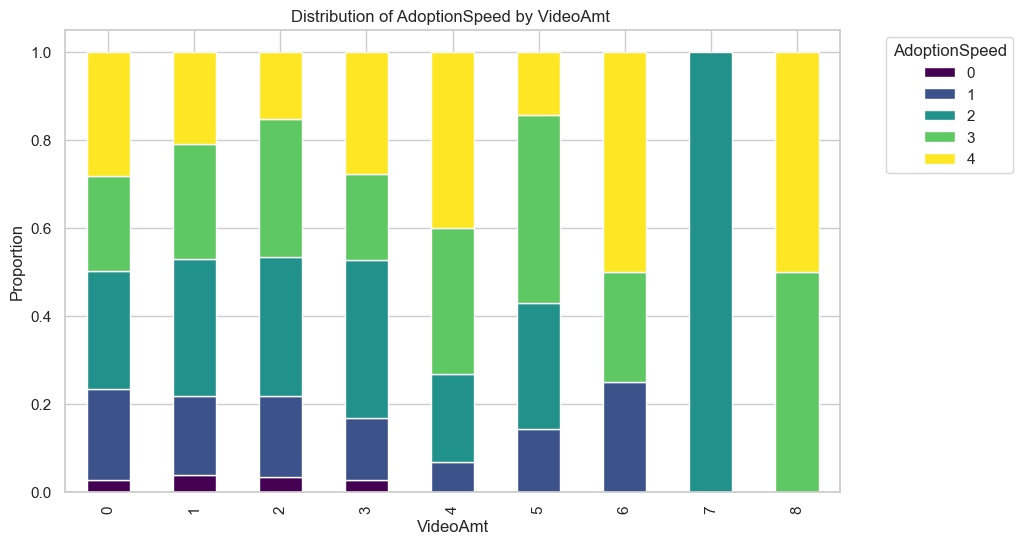

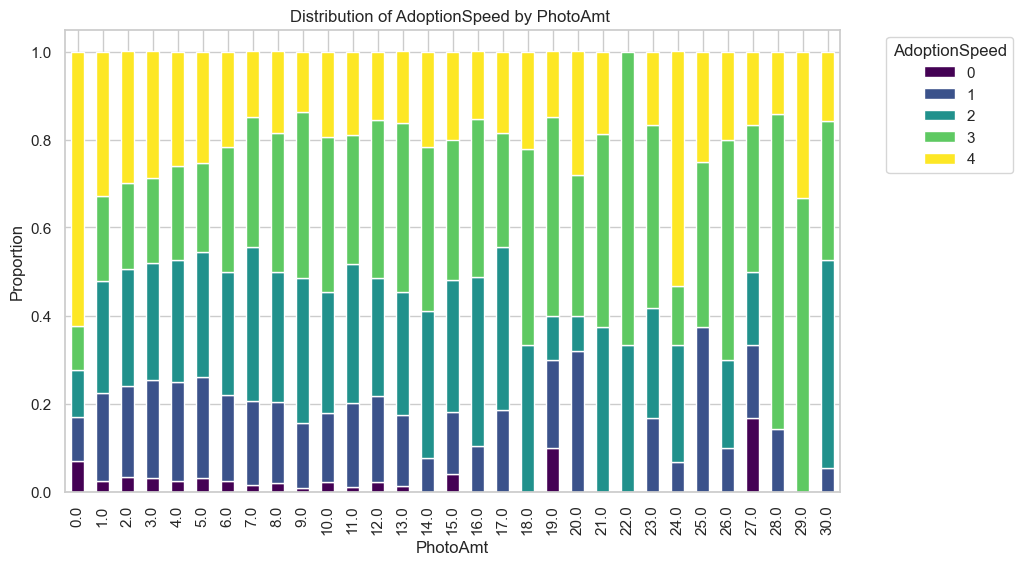

In [107]:
# Función para crear gráficos de barras apiladas
def stacked_bar_plot(df, column, title):
    # Calcular la distribución de AdoptionSpeed dentro de cada categoría
    distribution = df.groupby([column, 'AdoptionSpeed']).size().unstack(fill_value=0)
    distribution_norm = distribution.div(distribution.sum(axis=1), axis=0)
    
    # Graficar
    distribution_norm.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
    plt.title(title)
    plt.xlabel(column)
    plt.ylabel('Proportion')
    plt.legend(title='AdoptionSpeed', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# Gráficos para perros
for column in ['VideoAmt','PhotoAmt']:
    stacked_bar_plot(df, column, f'Distribution of AdoptionSpeed by {column} ')

¿Ayuda tener más o menos fotos con la velocidad de adopción?

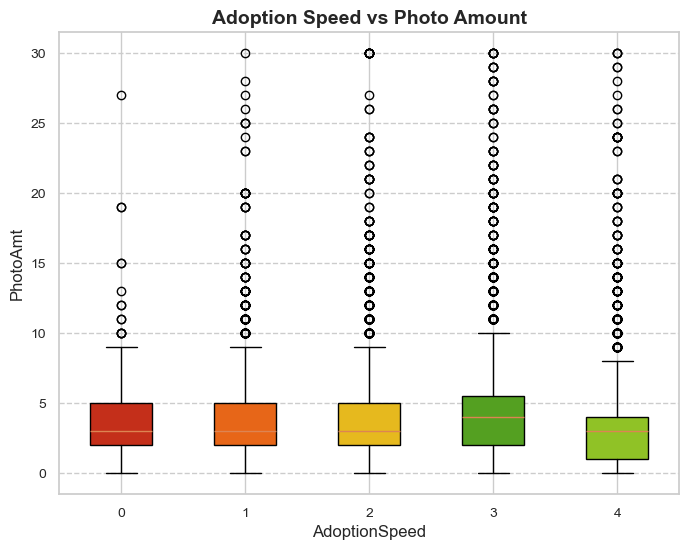

In [108]:
# Crear una lista de listas de valores para cada nivel de 'AdoptionSpeed'
data = []
for level in sorted(df['AdoptionSpeed'].unique()):
    values = df.loc[df['AdoptionSpeed'] == level, 'PhotoAmt'].tolist()
    data.append(values)

# Crear el boxplot con colores personalizados
colors = ['#C42F1A', '#E76618', '#E6B91E', '#54A021', '#90C226']
plt.figure(figsize=(8, 6))
boxplot = plt.boxplot(data, labels=sorted(df['AdoptionSpeed'].unique()), patch_artist=True)

# Personalizar colores de las cajas
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

# Establecer etiquetas y títulos
plt.xlabel('AdoptionSpeed', fontsize=12)
plt.ylabel('PhotoAmt', fontsize=12)
plt.title('Adoption Speed vs Photo Amount', fontsize=14, fontweight='bold')

# Personalizar el estilo del gráfico
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--')

# Mostrar el gráfico
plt.show()

No parece haber una gran diferencia en el número de fotos para las velocidades de adopción 0, 1 y 2. Sin embargo, parece haber más fotos para las mascotas con una velocidad de adopción 3.

### 3.12 Velocidad de adopción en función de las descripciones

¿Ayuda tener una descripción más larga a que sean adoptados más rapidamente?

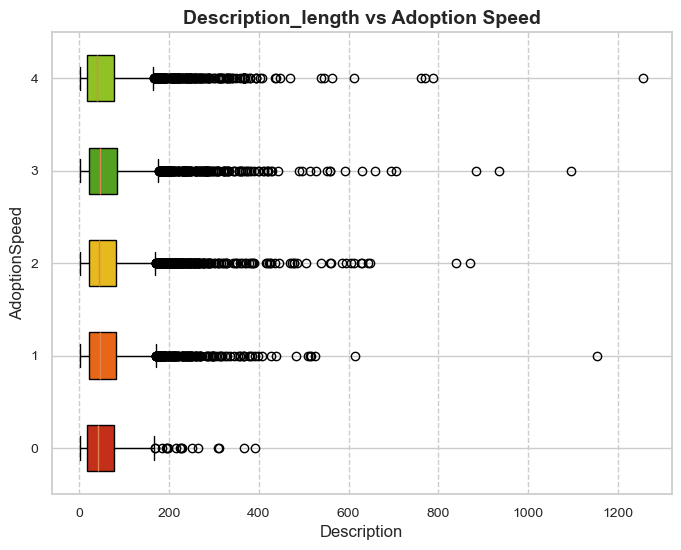

In [111]:
# Calcular la longitud de las palabras en la columna 'Description'
df['Description_length'] = df['Description'].apply(lambda x: len(str(x).split()))

# Crear una lista de listas de valores para cada nivel de 'AdoptionSpeed'
data = []
colors = ['#C42F1A', '#E76618', '#E6B91E', '#54A021', '#90C226']
for level, color in zip(sorted(df['AdoptionSpeed'].unique()), colors):
    values = df.loc[df['AdoptionSpeed'] == level, 'Description_length'].tolist()
    data.append(values)

# Crear el boxplot con colores personalizados
plt.figure(figsize=(8, 6))
boxplot = plt.boxplot(data, labels=sorted(df['AdoptionSpeed'].unique()), patch_artist=True, vert=False)

# Personalizar colores de las cajas
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

# Establecer Description_length y títulos
plt.xlabel('Description', fontsize=12)
plt.ylabel('AdoptionSpeed', fontsize=12)
plt.title('Description_length vs Adoption Speed', fontsize=14, fontweight='bold')

# Personalizar el estilo del gráfico
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--')

# Mostrar el gráfico
plt.show()

Si bien se observan varios Outliers o valores atípicos, no se aprecia una diferencia significativa entre la cantidad de palabras y la velocidad de adopción.

### 3.13 Velocidad de Adopción según el nombre

<Axes: xlabel='tieneNombre', ylabel='count'>

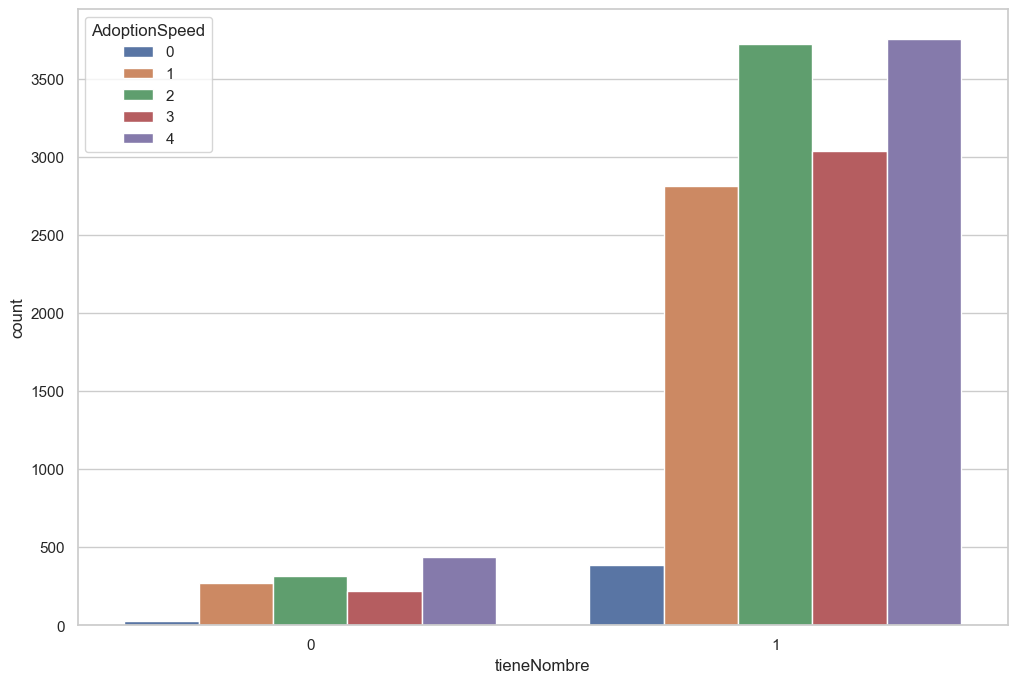

In [113]:
df['tieneNombre'] = 1
df.loc[df['Name'] == 'Unnamed', 'tieneNombre'] = 0

sns.countplot(x='tieneNombre', data=df, hue='AdoptionSpeed')

### 3.14 Distribución de la edad en las mascotas

Text(0.5, 1.0, 'Distribution of pets age in Months')

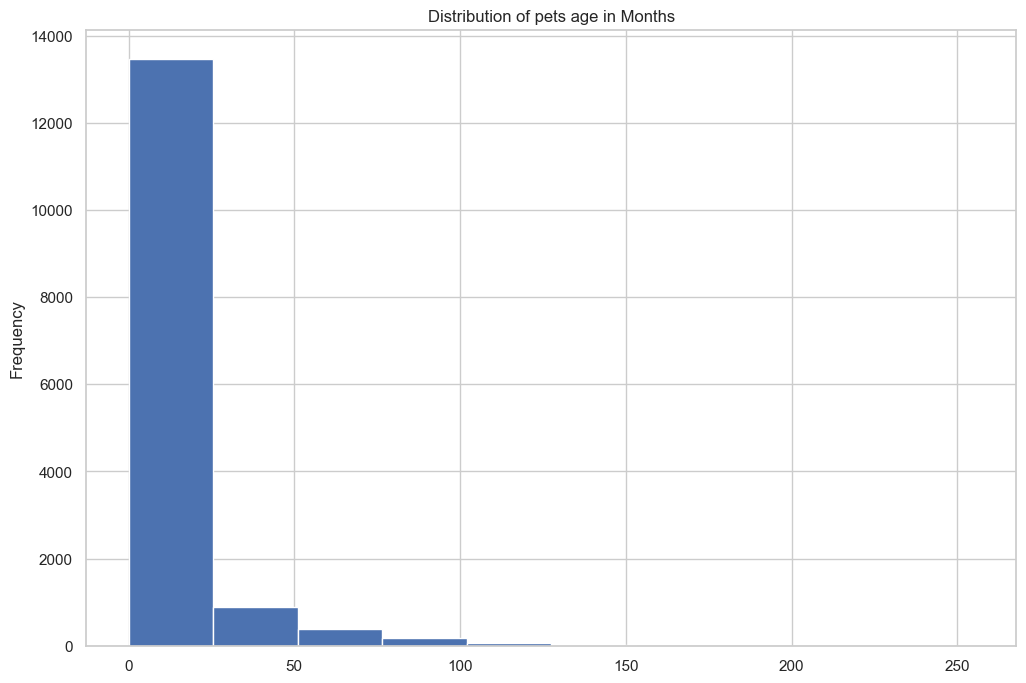

In [115]:
df['Age'].plot(kind='hist')
plt.title('Distribution of pets age in Months')

### 3.15 Análisis del Texto Libre de la Descripción

#### 3.15.1 Limpiar palabras

Vamos a trabajar con la librería Spacy para limpiar los textos de signos de puntuación y caracteres especiales.

In [ ]:
# !python -m spacy download en_core_web_sm

In [ ]:
#Instancio nlp
nlp = spacy.load("en_core_web_sm")

In [ ]:
def clean_text(text):
  clean_text = []
  for token in nlp(text):
    if (
        not token.is_stop
        and not token.is_punct
        and not token.like_url
    ):
        clean_text.append(token.lemma_.lower())

  return " ".join(clean_text)

In [ ]:
def remove_html(text):
  soup = BeautifulSoup(text)

  return soup.get_text()

In [ ]:
# Tarda 10 minutos
df['text_clean']=df['Description'].astype(str).apply(clean_text)

In [ ]:
df['text_clean']=df['text_clean'].astype(str).apply(remove_html)

#### 3.15.2 Tokenizar Palabras más frecuentes

In [ ]:
def get_longitud_text(text):
  return len(text)

In [ ]:
df['text_clean'] = df['text_clean'].astype(str)
df['Description_length'] = df['text_clean'].apply(get_longitud_text)
df['Description_length'].describe()

In [ ]:
plt.figure(figsize=(20, 10))
sns.histplot(df['Description_length'], kde=True, bins=50)
plt.title('Longitud de las Descripciones', fontdict={'fontsize': 12,'fontweight':'bold'})
plt.ylabel('Cantidad de Descripciones')
plt.xlabel('Longitud de las Descripciones')
plt.grid(linewidth=0.3)
plt.show()

In [ ]:
FreqOfWords = df['Description'].str.split(expand=True).stack().value_counts()
FreqOfWords_top200 = FreqOfWords[:200]
FreqOfWords_top200.head(50)

#### 3.15.3 Wordcloud para descripciones limpias

In [ ]:
nlp.Defaults.stop_words.add("nan")

In [ ]:
%matplotlib inline
def cloud(data,backgroundcolor = 'black', width = 800, height = 600):
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color = backgroundcolor,
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [ ]:
cloud(' '.join(df['text_clean']))

In [ ]:
# nltk.download('punkt')
# nltk.download('stopwords')

In [ ]:
# Obtener todas las descripciones como una lista de palabras
all_descriptions = ' '.join(df['text_clean'].dropna())  # Concatenar todas las descripciones

# Tokenización y eliminación de stopwords
stop_words = set(stopwords.words('english'))  # Definir stopwords en inglés
word_tokens = word_tokenize(all_descriptions.lower())  # Tokenización y convertir a minúsculas
filtered_words = [word for word in word_tokens if word.isalnum() and word not in stop_words]  # Filtrar stopwords y no palabras alfanuméricas

# Obtener la frecuencia de las palabras después de la limpieza
freq_of_words = pd.Series(filtered_words).value_counts()

print(freq_of_words.head(20))  # Mostrar las 20 palabras más frecuentes

In [ ]:
# Concatenar todas las descripciones en un solo texto
all_descriptions = ' '.join(df['text_clean'].dropna())

# Tokenización y eliminación de stopwords
stop_words = set(stopwords.words('english'))  # Definir stopwords en inglés
word_tokens = word_tokenize(all_descriptions.lower())  # Tokenización y convertir a minúsculas
filtered_words = [word for word in word_tokens if word.isalnum() and word not in stop_words]  # Filtrar stopwords y no palabras alfanuméricas

# Crear DataFrame con las palabras y sus frecuencias
freq_of_words = pd.Series(filtered_words).value_counts().reset_index()
freq_of_words.columns = ['Word', 'Frequency']

# Seleccionar las 20 palabras más frecuentes
top_words = freq_of_words.head(20)

# Configurar el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Crear el gráfico de barras horizontal
sns.barplot(x='Frequency', y='Word', data=top_words, palette='viridis')
plt.title('Top 20 Most Frequent Words in Pet Descriptions')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

#### 3.15.4 NER

Named entity recognition (NER) es una técnica de NLP que automáticamente identifica entidades en un texto y las clasifica en alguna categoría predefinida.

<br>Una entidad puede ser:

- Nombres
- Organizaciones
- Ubicaciones
- Fechas
- Cantidades
- Valores monetarios
- Porcentajes
- Y más..

<br>Utilizaremos spacy para extraer las entidades de las descripciones.

In [ ]:
def get_entities(text:str):
  doc=nlp(text)
  ents = []
  if doc.ents: 
    for ent in doc.ents:
      ents.append(ent.text)
  return ents

In [ ]:
df["NER"] = df["text_clean"].apply(get_entities)

In [ ]:
df[['text_clean', 'NER']].sample(10)

Aplicamos EXPLODE
<br>
En pandas, la función .explode() nos permite transformar una filas de un dataset que tienen una lista (como nuestra columna NER) en muchas filas (una por elemento en la lista).
<br>
Aplicamos dicha función a nuestra columna NER pero sin modificar el df original, guardando el resultado en otro df.

In [ ]:
df_exploded = df.explode("NER")
df_exploded.head()

Wordcloud de los NER

In [ ]:
df_exploded['NER_NER'] = df_exploded['NER'].apply(lambda x : str(x or ""))

In [ ]:
df_exploded = df_exploded[df_exploded['NER_NER'] != 'nan']
cloud(' '.join(df_exploded['NER_NER']))

Ahora, agrupando por NER podemos obtener cuáles son las entidades que aparecen más frecuentemente en estas descripciones.
<br>
Obtenemos el top 20 de entidades más frecuentes.

In [ ]:
df_ner_exploded = df_exploded[df_exploded.NER.apply(lambda x: not x.isnumeric())][['RescuerID','NER']].groupby("NER").count().sort_values(by="RescuerID", ascending=False).rename(columns = {'RescuerID':'cantidad'}).reset_index().head(20)

In [ ]:
df_ner_exploded

In [ ]:
sns.barplot(data=df_ner_exploded, x="cantidad", y="NER")

Las primeras 20 adopciones que están asociadas a más NERs

In [ ]:
df_exploded.groupby('RescuerID').agg({'NER':'count'}).sort_values(by="NER", ascending=False).rename(columns = {'NER':'cantidad_NER'}).reset_index().head(20)

#### 3.15.5 Part of speech


POS es el proceso mediante el cual clasificamos a las palabras de un texto en categorías gramaticales. Para esto, los modelos se basan no solo en la palabra en sí, sino también en su contexto. Es decir, se busca identificar sustantivos, verbos, adjetivos, etc dentro de un texto.
<br>
Al igual que NER, para identificar POS en en el texto de las descripciones, utilizamos los modelos de spacy.
<br>
Definimos una función que dado un texto, retorne una lista de todos sus sustantivos. En caso de que no contenga sustantivos, debe retornar lista vacia.

In [ ]:
def get_nouns(text):
  doc = nlp(text)
  nouns = []
  for token in doc:
    if token.pos_ == "NOUN":
      nouns.append(token.text)
  return nouns

In [ ]:
df["NOUNS"] = df["text_clean"].apply(get_nouns)

Hacemos un explode, como hicimos con los NER

In [ ]:
df_exploded_nouns = df.explode("NOUNS")
df_exploded_nouns.head()

Sustantivos más repetidos.

In [ ]:
df_exploded_nouns[['NOUNS','RescuerID']].groupby("NOUNS").count().sort_values(by="RescuerID", ascending=False).rename(columns={'RescuerID':'cantidad'}).reset_index().head(20)

Wordcloud a partir de los sustantivos

In [ ]:
df_exploded_nouns['NOUNS'] = df_exploded_nouns['NOUNS'].apply(lambda x : str(x or ""))
cloud(' '.join(df_exploded_nouns['NOUNS']))

#### 3.15.6 Noun chunks


Spacy también nos permite extraer "noun chunks" de un texto. Noun chunks son sustantivos en conjunto con cualquier palabra que dependa de ellos o los acompañe.

Creamos una función que dado un texto retorne un listado de noun chunks. Luego aplicamos la función al dataframe y almacenamos resultados en la columna "NOUN_CHUNKS"

In [ ]:
def get_noun_chunks(text:str):
  doc = nlp(text)
  return [nc for nc in doc.noun_chunks]

In [ ]:
df["NOUN_CHUNKS"] = df["text_clean"].apply(get_noun_chunks)

In [ ]:
df.head(1)

In [ ]:
df_exploded_nouns_chunks = df.explode("NOUN_CHUNKS")
df_exploded_nouns_chunks.head()

#### 3.15.7 Sentiment Analysis (Análisis de Sentimiento)


Para análisis de sentimientos utilizamos textblob.

Definimos una función get_sentiment que dado un texto, nos retorne:

- la palabra "POS" si polarity > 0.1
- la palabra "NEU" si polarity ≥ -0.1 & polarity ≤ 0.1
- la palabra "NEG" si polarity < -0.1

Luego la aplicarmos a todo el df y almacenamos los resultados en la columna "SENTIMENT"

In [ ]:
def get_sentiment(text):
  sent = TextBlob(text).sentiment.polarity

  if sent > 0.1:
    return "POS"
  
  if sent >= -0.1 and sent <= 0.1:
    return "NEU"

  if sent < 0.1:
    return "NEG"

In [ ]:
df["SENTIMENT"] = df["text_clean"].apply(get_sentiment)

In [ ]:
df.head(1)

Cuantos reviews asociadas a sentimientos (POS, NEU, NEG)

In [ ]:
df_copy = df[['SENTIMENT','RescuerID']].copy()
df_copy = df_copy.rename(columns = {'RescuerID' : 'cantidad_reviews'})
a = df_copy.groupby("SENTIMENT").count()
a

Gráfico de torta a partir de los datos anteriores

In [ ]:
data = a.cantidad_reviews
labels = ['NEG','NEU','POS']

colors = sns.color_palette('pastel')[0:5]

plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

Polaridad y Subjetividad de las Descripciones

POLARITY

Puede tomar valores en el rango [-1, 1], donde -1 define un sentimiento negativo y 1 un sentimiento positivo. Las palabras de negación, invierten la polaridad.

SUBJECTIVITY

Puede tomar valores en el rango [0, 1]. Cuantifica la cantidad de opinión personal que contiene el texto. Mientras más alta sea, significa que el texto contiene muchas opiniones personales en lugar de información basada en hechos.

In [ ]:
def get_polarity(text):
  return TextBlob(text).sentiment.polarity

def get_subjectivity(text):
  return TextBlob(text).sentiment.subjectivity

In [ ]:
df["polarity"] = df["text_clean"].apply(get_polarity)

In [ ]:
df["subjectivity"] = df["text_clean"].apply(get_subjectivity)

In [ ]:
plt = plt.figure(figsize=(16, 7))
sns.set(style="darkgrid")

sns.histplot(data=df, x="polarity", color="skyblue", label="Polarity", kde=True)
sns.histplot(data=df, x="subjectivity", color="red", label="Subjectivity", kde=True)

plt.legend() 
plt.show()

In [ ]:
df[['polarity','subjectivity']].describe()

Conclusión: Valores positivos de subjetividad y polaridad indican la presencia de descripciones asociadas a sentimientos positivos.

Agrupamos Sustantivas y Sentimientos

In [ ]:
noun_sentiments = df.explode("NOUNS").groupby(["NOUNS", "SENTIMENT"], as_index=False).agg({"text_clean": "count"}).sort_values(by="NOUNS", ascending=False).rename(columns={'text_clean':'cantidad'})
noun_sentiments.sample(20)

Sustantivos asociados a adopciones más negativas

In [ ]:
noun_sentiments[noun_sentiments.SENTIMENT == "NEG"].sort_values(by="cantidad", ascending=False).head(10)

Sustantivos asociados a adopciones más positivas

In [ ]:
noun_sentiments[noun_sentiments.SENTIMENT == "POS"].sort_values(by="cantidad", ascending=False).head(10)

#### 3.15.8 KeyBert


Ahora vamos a analizar las keywords.

In [ ]:
kw_model = KeyBERT()

In [ ]:
# tarda 20 minutos
df["KEYWORDS"] = df['text_clean'].apply(lambda x: kw_model.extract_keywords(x, top_n=3, keyphrase_ngram_range=(1,1)))

In [ ]:
df.head(1)

Podemos ver que además de la keyword, nos trae un score para cada keyword.

Vamos a eliminar el score y quedarnos únicamente con las kw.

In [ ]:
df["KEYWORDS"] = df.KEYWORDS.apply(lambda keywords: [k[0] for k in keywords])

In [ ]:
df.head(1)

Ahora podemos ver la popularidad de las keywords:

In [ ]:
#plt.figure(figsize=(20,6))
ax = sns.countplot(y=df.explode("KEYWORDS").KEYWORDS, 
              order=df.explode("KEYWORDS").KEYWORDS.value_counts().index[:30]
              )


ax.bar_label(ax.containers[0])

plt.title("KEYWORDS popularity - TOP 30")
plt.xticks(rotation=45)
plt.show()

In [ ]:
df_keywords = df.explode("KEYWORDS")

In [ ]:
df_keywords.head(1)

WordCloud para las keywords

In [ ]:
import matplotlib.pyplot as plt
# fig, ax = plt.subplots(1,2, figsize = (20,10))
import seaborn as sns

plt.figure(figsize=(20,6))
df_keywords['KEYWORDS'] = df_keywords['KEYWORDS'].apply(lambda x : str(x or ""))

cloud(' '.join(df_keywords['KEYWORDS']))

#### 3.15.9 BERTopic

Ahora utilizaremos BERTopic para extraer tópicos.

In [ ]:
topic_model = BERTopic(calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(df["text_clean"].values)

In [ ]:
topics_data = topic_model.get_topic_info()
topics_data

El topico -1 corresponde a outliers.

In [ ]:
df["TOPIC_ID"] = topics
df = df.merge(topics_data, left_on="TOPIC_ID", right_on="Topic", how="left")
df = df.rename(columns={"Name": "TOPIC_NAME", "Count": "TOPIC_POPULARITY"})
df = df.drop(["Topic"], axis=1)
df.head(20)

In [ ]:
topic_model.visualize_topics()

WordCloud de tópicos

In [ ]:
cloud(' '.join(df['TOPIC_NAME']))

#### 3.15.10 Bag of Words / TF-IDF

In [ ]:
# //TODO

#### 3.15.11 Análisis de texto por speed adoption

In [ ]:
# //TODO

### 3.16 Análisis de los nombres

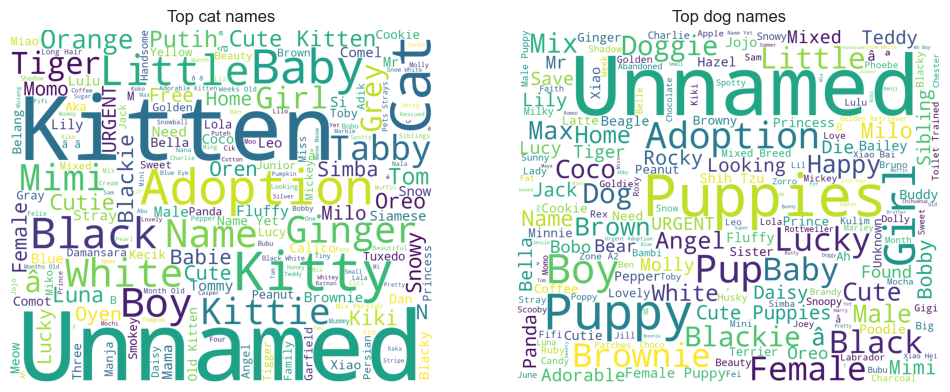

In [128]:
plt.subplot(1, 2, 1)
text_cat = ' '.join(df.loc[df['TypeNombre'] == 'Cat', 'Name'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white',
                      width=1200, height=1000).generate(text_cat)
plt.imshow(wordcloud)
plt.title('Top cat names')
plt.axis("off")

plt.subplot(1, 2, 2)
text_dog = ' '.join(df.loc[df['TypeNombre'] == 'Dog', 'Name'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white',
                      width=1200, height=1000).generate(text_dog)
plt.imshow(wordcloud)
plt.title('Top dog names')
plt.axis("off")

plt.show()

## 4. Pre Procesamiento de datos


## 5. Feature Engeneering


### 5.1 Creación de variables

#### 5.1.1 Edad categórica

A partir del campo edad crear {cachorro, joven, adulto, viejo}
<p>Perros </p>
<li> Cachorro: 0-12 meses </li>
<li> Joven: 13-36 meses </li>
<li> Adulto: 37-84 meses (3-7 años) </li>
<li> Viejo: >84 meses (más de 7 años) </li>
<p>Gatos </p>
<li> Cachorro: 0-12 meses </li> 
<li> Joven: 13-24 meses </li>
<li> Adulto: 25-60 meses (2-5 años) </li>
<li> Viejo: >60 meses (más de 5 años) </li>

In [ ]:
def clasificar_edad(row):
    age = row['Age']
    tipo = row['TypeNombre']
    
    if tipo == 'Dog':
        if age <= 12:
            return 'cachorro'
        elif age <= 36:
            return 'joven'
        elif age <= 84:
            return 'adulto'
        else:
            return 'viejo'
    elif tipo == 'Cat':
        if age <= 12:
            return 'cachorro'
        elif age <= 24:
            return 'joven'
        elif age <= 60:
            return 'adulto'
        else:
            return 'viejo'
    else:
        return 'desconocido'  # Por si acaso hay otros tipos

df['EdadNombre'] = df.apply(clasificar_edad, axis=1)

#### 5.1.2 Característica de la raza

Indicamos si es es de compañía, pastor, caza y protección

In [ ]:
# leer diccionario de razas
df_breeds = pd.read_csv('./input/petfinder-adoption-prediction/breed_labels.csv')
# leer clasificación de razas de Claude
claude_class = pd.read_csv('./input/petfinder-adoption-prediction/claude_breed_class.csv',sep=';')
# Merge de razas y clasificación
df_breeds = df_breeds.merge(claude_class, on='BreedName', how='left')

#  Función para obtener el tipo de raza en el DataFrame principal

def get_breed_type(row):
    if row['Breed3'] == 0 or row['Breed3'] == 307: # si es mestizo o desconocido
        return ["mestizo", "Compañía"]
    else:
        breed_info = df_breeds[df_breeds['BreedID'] == row['Breed3']][['BreedName', 'tipo']].values # si es una raza conocida
        if len(breed_info) > 0:
            return breed_info[0]
        else:
            return ["Desconocido", "Desconocido"]

# Crear una nueva columna con la raza principal
df["Breed3"] = ""
df.loc[df["Breed1"] == 0, "Breed3"] = df["Breed2"] # si la raza principal es 0, se toma la raza secundaria
df.loc[df["Breed1"] == 307, "Breed3"] = 307 # si la raza principal es mestizo, se asigna 307
df.loc[(df["Breed1"] != 0)&(df["Breed1"]!=307), "Breed3"] = df["Breed1"] # si la raza principal es conocida, se asigna

# Aplicar la función a cada fila del DataFrame con la clasiicación de razas
df[['BreedName', 'breed_type']] = df.apply(get_breed_type, axis=1, result_type='expand')

#### 5.1.3 Colores: unicolor, bicolor y tricolor

In [139]:
def determine_color_type(colour):
    parts = colour.split('_')
    if len(parts) == 1:
        return 'unicolor'
    elif len(parts) == 2:
        return 'bicolor'
    elif len(parts) == 3:
        return 'tricolor'
    else:
        return 'unknown'  # Por si hay algún formato inesperado

df['tipo_color'] = df['Colors'].apply(determine_color_type)


In [140]:
df['tipo_color'].value_counts()

tipo_color
bicolor     6133
unicolor    4471
tricolor    4389
Name: count, dtype: int64

#### 5.1.4 Dummy: es de raza

In [ ]:
df['es_raza_pura'] = df['tipo_raza'].apply(lambda x: 'Si' if x == 'raza_pura' else 'No')
df['es_raza_pura'].value_counts()

#### 5.1.5 Dummy: Tiene descripción

In [ ]:
df["tieneDescripcion"] = df["Description"].apply(lambda x: "No" if x == "Undescripted" else "Si")
df['tieneDescripcion'].value_counts()

#### 5.1.6 Longitud de la descripción

In [ ]:
df['Description_length'] = df['Description'].apply(lambda x: len(str(x).split()))

#### 5.1.7 Dummy: está vacunado

In [ ]:
df['estaVacunado'] = df['Vaccinated'].apply(lambda x: "Si" if x == 1 else ("No" if x == 2 else "NA"))
df['estaVacunado'].value_counts()

#### 5.1.8 Dummy: está desparacitado

In [ ]:
df['estaDesparacitado'] = df['Dewormed'].apply(lambda x: "Si" if x == 1 else ("No" if x == 2 else "NA"))
df['estaDesparacitado'].value_counts()

#### 5.1.9 Dummy: está esterilizado

In [ ]:
df['estaEsterilizado'] = df['Sterilized'].apply(lambda x: "Si" if x == 1 else ("No" if x == 2 else "NA"))
df['estaEsterilizado'].value_counts()

#### 5.1.10 Dummy: Salud

In [ ]:
df['estadoSalud'] = df['Health'].apply(lambda x: "NA" if x == 0 else ("Saludable" if x == 1 else "No Saludable"))
df['estadoSalud'].value_counts()

#### 5.1.11 Dummy: tiene nombre

In [ ]:
df['tieneNombre'] = df['Name'].apply(lambda x: "Sin nombre" if x == "Unnamed" else "Con Nombre")
df['tieneNombre'].value_counts()

### 5.2 Normalizar variables numéricas

Casi todas las variables numéricas presentan outliers. Realizamos la normalización como ejercicio práctico, entendiendo que no afectará al modelo de forma negativa, aunque esta no sea neceria para los modelos que utilizaremos en la próxima sección.

In [ ]:
df.select_dtypes(include=['int64', 'float64']).columns

In [ ]:
# TODO: Ver variables numericas a considerar

In [ ]:
numerical_columns = ['Age', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt', 'Description']

In [ ]:
# Estandarizar las columnas numéricas
scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

### 5.3 Variables categóricas: One Hot Encoding

In [ ]:
categorical_columns = df.select_dtypes(exclude=['number']).columns
categorical_columns

In [ ]:
# TODO: Ver variables caegoricas a considerar

In [ ]:
df = pd.get_dummies(df, columns=categorical_columns)

## 6. Separa la base de Test y Train


In [142]:
SEED = 12345 
TEST_SIZE = 0.2 

Gender
2    7277
1    5536
3    2180
Name: count, dtype: int64

In [ ]:
#Separo un 20% para test estratificado opr target
train, test = train_test_split(df,
                               test_size = TEST_SIZE,
                               random_state = SEED,
                               stratify = df.AdoptionSpeed)

In [ ]:
#Armo listas con features de texto y numericas
char_feats = [f for f in df.columns if df[f].dtype=='O']
numeric_feats = [f for f in df.columns if df[f].dtype!='O']

In [ ]:
# TODO: Ver variables a considerar

In [ ]:
#Defino features a usar en un primer modelo de prueba
features = ['Type',
 'Age',
 'Breed1',
 'Breed2',
 'Gender',
 'Color1',
 'Color2',
 'Color3',
 #'MaturitySize',
 #'FurLength',
 'Vaccinated',
 'Dewormed',
 'Sterilized',
 'Health',
 'Quantity',
 'Fee',
 'State',
 'VideoAmt',
 'PhotoAmt']

label = 'AdoptionSpeed'

In [ ]:
#Genero dataframes de train y test con sus respectivos targets
X_train = train[features]
y_train = train[label]

X_test = test[features]
y_test = test[label]

### 7. Para la parte de Train, armar un esquema de Cross Validation


## 8. Desarrollar modelo datos estructurados

### 8.1 Modelo 1: LightGBM

#### 8.1.1 Optimización de hiperparámetros con Optuna

In [ ]:
#Genero una metrica para que lightGBM haga la evaluación y pueda hacer early_stopping en el cross validation
def lgb_custom_metric_kappa(dy_pred, dy_true):
    metric_name = 'kappa'
    value = cohen_kappa_score(dy_true.get_label(),dy_pred.argmax(axis=1),weights = 'quadratic')
    is_higher_better = True
    return(metric_name, value, is_higher_better)

#Funcion objetivo a optimizar. En este caso vamos a hacer 5fold cv sobre el conjunto de train. 
# El score de CV es el objetivo a optimizar. Ademas vamos a usar los 5 modelos del CV para estimar el conjunto de test,
# registraremos en optuna las predicciones, matriz de confusion y el score en test.
# CV Score -> Se usa para determinar el rendimiento de los hiperparametros con precision 
# Test Score -> Nos permite testear que esta todo OK, no use (ni debo usar) esos datos para nada en el entrenamiento 
# o la optimizacion de hiperparametros

def cv_es_lgb_objective(trial):

    #PArametros para LightGBM
    lgb_params = {      
                        #PArametros fijos
                        'objective': 'multiclass',
                        'verbosity':-1,
                        'num_class': len(y_train.unique()),
                        #Hiperparametros a optimizar utilizando suggest_float o suggest_int segun el tipo de dato
                        #Se indica el nombre del parametro, valor minimo, valor maximo 
                        #en elgunos casos el parametro log=True para parametros que requieren buscar en esa escala
                        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
                        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
                        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
                        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
                        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
                        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
                        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
                        } 

    #Voy a generar estimaciones de los 5 modelos del CV sobre los datos test y los acumulo en la matriz scores_ensemble
    scores_ensemble = np.zeros((len(y_test),len(y_train.unique())))

    #Score del 5 fold CV inicializado en 0
    score_folds = 0

    #Numero de splits del CV
    n_splits = 5

    #Objeto para hacer el split estratificado de CV
    skf = StratifiedKFold(n_splits=n_splits)

    for i, (if_index, oof_index) in enumerate(skf.split(X_train, y_train)):
        
        #Dataset in fold (donde entreno) 
        lgb_if_dataset = lgb.Dataset(data=X_train.iloc[if_index],
                                        label=y_train.iloc[if_index],
                                        free_raw_data=False)
        
        #Dataset Out of fold (donde mido la performance del CV)
        lgb_oof_dataset = lgb.Dataset(data=X_train.iloc[oof_index],
                                        label=y_train.iloc[oof_index],
                                        free_raw_data=False)

        #Entreno el modelo
        lgb_model = lgb.train(lgb_params,
                                lgb_if_dataset,
                                valid_sets=lgb_oof_dataset,
                                callbacks=[lgb.early_stopping(10, verbose=False)],
                                feval = lgb_custom_metric_kappa
                                )
        
        #Acumulo los scores (probabilidades) de cada clase para cada uno de los modelos que determino en los folds
        #Se predice el 20% de los datos que separe para tes y no uso para entrenar en ningun fold
        scores_ensemble = scores_ensemble + lgb_model.predict(X_test)
        
        #Score del fold (registros de dataset train que en este fold quedan out of fold)
        score_folds = score_folds + cohen_kappa_score(y_train.iloc[oof_index], 
                                                            lgb_model.predict(X_train.iloc[oof_index]).argmax(axis=1),weights = 'quadratic')/n_splits


    #Guardo prediccion del trial sobre el conjunto de test
    # Genero nombre de archivo
    predicted_filename = os.path.join(PATH_TO_TEMP_FILES,f'test_{trial.study.study_name}_{trial.number}.joblib')
    # Copia del dataset para guardar la prediccion
    predicted_df = test.copy()
    # Genero columna pred con predicciones sumadas de los 5 folds
    predicted_df['pred'] = [scores_ensemble[p,:] for p in range(scores_ensemble.shape[0])]
    # Grabo dataframe en temp_artifacts
    dump(predicted_df, predicted_filename)
    # Indico a optuna que asocie el archivo generado al trial
    upload_artifact(trial, predicted_filename, artifact_store)    

    #Grabo natriz de confusion
    #Nombre de archivo
    cm_filename = os.path.join(PATH_TO_TEMP_FILES,f'cm_{trial.study.study_name}_{trial.number}.jpg')
    #Grabo archivo
    plot_confusion_matrix(y_test,scores_ensemble.argmax(axis=1)).write_image(cm_filename)
    #Asocio al trial
    upload_artifact(trial, cm_filename, artifact_store)

    #Determino score en conjunto de test y asocio como metrica adicional en optuna
    test_score = cohen_kappa_score(y_test,scores_ensemble.argmax(axis=1),weights = 'quadratic')
    trial.set_user_attr("test_score", test_score)

    #Devuelvo score del 5fold cv a optuna para que optimice en base a eso
    return(score_folds)

In [ ]:
#Inicio el store de artefactos (archivos) de optuna
artifact_store = FileSystemArtifactStore(base_path=PATH_TO_OPTUNA_ARTIFACTS)

#Genero estudio
study = optuna.create_study(direction='maximize',
                            storage="sqlite:///db.sqlite3",  # Specify the storage URL here.
                            study_name="04 - LGB Multiclass CV",
                            load_if_exists = True)
#Corro la optimizacion
study.optimize(cv_es_lgb_objective, n_trials=100)

In [ ]:
#Obtenemos mejor resultado
study.best_params

In [ ]:
# TODO: Graficos

#### 8.1.2 Optimización de hiperparámetros con GridSearch

In [ ]:
# Funcion para levantar el modelo
def pickle_load(name_model):
    Pkl_Filename = "RFC_Model.pkl"
    
    with open(Pkl_Filename, 'rb') as file:
        Pickled_RFC_Model = pickle.load(file)
        
    return Pickled_RFC_Model

In [ ]:
# Definir el custom scorer basado en cohen_kappa_score
def custom_kappa_scorer(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

kappa_scorer = make_scorer(custom_kappa_scorer)

In [ ]:
lgbm_params = {
    'objective': ['multiclass'],
    'verbosity': [-1],
    'num_class': [len(y_train.unique())],
    'lambda_l1': np.logspace(-8, 1, num=10),  # 10 valores logarítmicamente espaciados entre 1e-8 y 10
    'lambda_l2': np.logspace(-8, 1, num=10),  # 10 valores logarítmicamente espaciados entre 1e-8 y 10
    'num_leaves': list(range(2, 257, 25)),  # Valores entre 2 y 256
    'feature_fraction': np.linspace(0.4, 1.0, num=7),  # 7 valores linealmente espaciados entre 0.4 y 1.0
    'bagging_fraction': np.linspace(0.4, 1.0, num=7),  # 7 valores linealmente espaciados entre 0.4 y 1.0
    'bagging_freq': list(range(1, 8)),  # Valores entre 1 y 7
    'min_child_samples': list(range(5, 101, 10))  # 10 valores entre 5 y 100
}


# Crear una instancia de RandomForestClassifier
lgbm = lgb.LGBMClassifier(random_state=12345)

# Configurar GridSearchCV con 5-fold cross-validation
grid_search = GridSearchCV(estimator=lgbm, param_grid=lgbm_params, 
                           scoring=kappa_scorer, cv=5, n_jobs=-1, verbose=2)

# Ajustar el modelo a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros y el mejor score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
# Obtener el mejor modelo
best_model = grid_search.best_estimator_

print("Mejores hiperparámetros encontrados:", best_params)
print("Mejor score promedio de CV:", best_score)

# Evaluar en el conjunto de test
y_pred_test = grid_search.best_estimator_.predict(X_test)
test_score = cohen_kappa_score(y_test, y_pred_test, weights='quadratic')

print("Score en el conjunto de test:", test_score)


pkl_Filename = "LGB_Model.pkl"  
with open(pkl_Filename, 'wb') as file:
    pickle.dump(best_model, file)

### 8.2 Modelo 2: RandomForestClassifier

#### 8.2.1 Optimización de hiperparámetros con Optuna

In [ ]:
#Genero una metrica para que lightGBM haga la evaluación y pueda hacer early_stopping en el cross validation
def rfc_custom_metric_kappa(dy_pred, dy_true):
    metric_name = 'kappa'
    value = cohen_kappa_score(dy_true.get_label(),dy_pred.argmax(axis=1),weights = 'quadratic')
    is_higher_better = True
    return(metric_name, value, is_higher_better)

#Funcion objetivo a optimizar. En este caso vamos a hacer 5fold cv sobre el conjunto de train. 
# El score de CV es el objetivo a optimizar. Ademas vamos a usar los 5 modelos del CV para estimar el conjunto de test,
# registraremos en optuna las predicciones, matriz de confusion y el score en test.
# CV Score -> Se usa para determinar el rendimiento de los hiperparametros con precision 
# Test Score -> Nos permite testear que esta todo OK, no use (ni debo usar) esos datos para nada en el entrenamiento 
# o la optimizacion de hiperparametros

def cv_es_rfc_objective(trial):

    #Parametros para LightGBM
    rfc_params = {      
                        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
                        'max_depth': trial.suggest_int('max_depth', 3, 15),
                        #'max_depth': trial.suggest_int('max_depth', 3, 4)
                        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
                        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
                        } 

    #Voy a generar estimaciones de los 5 modelos del CV sobre los datos test y los acumulo en la matriz scores_ensemble
    scores_ensemble = np.zeros((len(y_test),len(y_train.unique())))

    #Score del 5 fold CV inicializado en 0
    score_folds = 0

    #Numero de splits del CV
    n_splits = 5

    #Objeto para hacer el split estratificado de CV
    skf = StratifiedKFold(n_splits=n_splits)

    for i, (if_index, oof_index) in enumerate(skf.split(X_train, y_train)):
        
        # Dataset in fold (donde entreno)
        X_if, y_if = X_train.iloc[if_index], y_train.iloc[if_index]
        
        # Dataset Out of fold (donde mido la performance del CV)
        X_oof, y_oof = X_train.iloc[oof_index], y_train.iloc[oof_index]

        # Crear el modelo RandomForestClassifier con los parámetros sugeridos
        rfc_model = rfc(**rfc_params, random_state=42)
        
        # Entrenar el modelo
        rfc_model.fit(X_if, y_if)
        
        # Acumular los scores (probabilidades) de cada clase para cada uno de los modelos que determino en los folds
        scores_ensemble += rfc_model.predict_proba(X_test)
        
        # Score del fold (registros de dataset train que en este fold quedan out of fold)
        score_folds += cohen_kappa_score(y_oof, rfc_model.predict(X_oof), weights='quadratic') / n_splits


    #Guardo prediccion del trial sobre el conjunto de test
    # Genero nombre de archivo
    predicted_filename = os.path.join(PATH_TO_TEMP_FILES,f'test_{trial.study.study_name}_{trial.number}.joblib')
    # Copia del dataset para guardar la prediccion
    predicted_df = test.copy()
    # Genero columna pred con predicciones sumadas de los 5 folds
    predicted_df['pred'] = [scores_ensemble[p,:] for p in range(scores_ensemble.shape[0])]
    # Grabo dataframe en temp_artifacts
    dump(predicted_df, predicted_filename)
    # Indico a optuna que asocie el archivo generado al trial
    upload_artifact(trial, predicted_filename, artifact_store)    

    #Grabo natriz de confusion
    #Nombre de archivo
    cm_filename = os.path.join(PATH_TO_TEMP_FILES,f'cm_{trial.study.study_name}_{trial.number}.jpg')
    #Grabo archivo
    plot_confusion_matrix(y_test,scores_ensemble.argmax(axis=1)).write_image(cm_filename)
    #Asocio al trial
    upload_artifact(trial, cm_filename, artifact_store)

    #Determino score en conjunto de test y asocio como metrica adicional en optuna
    test_score = cohen_kappa_score(y_test,scores_ensemble.argmax(axis=1),weights = 'quadratic')
    trial.set_user_attr("test_score", test_score)

    #Devuelvo score del 5fold cv a optuna para que optimice en base a eso
    return(score_folds)

In [ ]:
#Inicio el store de artefactos (archivos) de optuna
artifact_store = FileSystemArtifactStore(base_path=PATH_TO_OPTUNA_ARTIFACTS)

#Genero estudio
study = optuna.create_study(direction='maximize',
                            storage="sqlite:///db.sqlite3",  # Specify the storage URL here.
                            study_name="04 - Random Forest Multiclass CV",
                            load_if_exists = True)
#Corro la optimizacion
study.optimize(cv_es_rfc_objective, n_trials=100)

In [ ]:
#Obtenemos mejor resultado
study.best_params

#### 8.2.2 Optimización de hiperparámetros con GridSearch

In [ ]:
rf_params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Crear una instancia de RandomForestClassifier
rf = rfc(random_state=12345)


# Definir el custom scorer basado en cohen_kappa_score
def custom_kappa_scorer(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

kappa_scorer = make_scorer(custom_kappa_scorer)

# Configurar GridSearchCV con 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=rf_params, 
                           scoring=kappa_scorer, cv=5, n_jobs=-1, verbose=2)

# Ajustar el modelo a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros y el mejor score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
# Obtener el mejor modelo
best_model = grid_search.best_estimator_

print("Mejores hiperparámetros encontrados:", best_params)
print("Mejor score promedio de CV:", best_score)

# Evaluar en el conjunto de test
y_pred_test = grid_search.best_estimator_.predict(X_test)
test_score = cohen_kappa_score(y_test, y_pred_test, weights='quadratic')

print("Score en el conjunto de test:", test_score)


pkl_Filename = "RF_Model.pkl"  
with open(pkl_Filename, 'wb') as file:
    pickle.dump(best_model, file)

### 8.3 Modelo 3: XGBoost

#### 8.3.1 Optimización de hiperparámetros con Optuna

In [ ]:
# TODO: No pude hacer andar XGBOOST con optuna 

In [ ]:
#Genero una metrica para que lightGBM haga la evaluación y pueda hacer early_stopping en el cross validation
def xgb_custom_metric_kappa(dy_pred, dy_true):
    metric_name = 'kappa'
    value = cohen_kappa_score(dy_true.get_label(),dy_pred.argmax(axis=1),weights = 'quadratic')
    is_higher_better = True
    return(metric_name, value, is_higher_better)

#Funcion objetivo a optimizar. En este caso vamos a hacer 5fold cv sobre el conjunto de train. 
# El score de CV es el objetivo a optimizar. Ademas vamos a usar los 5 modelos del CV para estimar el conjunto de test,
# registraremos en optuna las predicciones, matriz de confusion y el score en test.
# CV Score -> Se usa para determinar el rendimiento de los hiperparametros con precision 
# Test Score -> Nos permite testear que esta todo OK, no use (ni debo usar) esos datos para nada en el entrenamiento 
# o la optimizacion de hiperparametros

def cv_es_xgboost_objective(trial):

    #PArametros para LightGBM
    xgb_params = {      
                        #PArametros fijos
                        # 'objective': 'multi:softmax',
                        'objective': 'multi:softmax',
                        # 'num_class': len(set(y_train)),
                        # 'eval_metric': 'mlogloss',
                        # 'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
                        # 'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
                        'lambda': trial.suggest_loguniform('lambda', 0.6, 0.7)
                        # 'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
                        # 'max_depth': trial.suggest_int('max_depth', 3, 10),
                        # 'eta': trial.suggest_loguniform('eta', 0.01, 0.1),
                        # 'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
                        # 'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
                        # 'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
                        # 'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
                        # 'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-8, 1.0)
                        } 

    #Voy a generar estimaciones de los 5 modelos del CV sobre los datos test y los acumulo en la matriz scores_ensemble
    scores_ensemble = np.zeros((len(y_test),len(y_train.unique())))

    #Score del 5 fold CV inicializado en 0
    score_folds = 0

    #Numero de splits del CV
    n_splits = 5

    #Objeto para hacer el split estratificado de CV
    skf = StratifiedKFold(n_splits=n_splits)

    for i, (if_index, oof_index) in enumerate(skf.split(X_train, y_train)):
        
        # Dataset in fold (donde entreno)
        X_if, y_if = X_train.iloc[if_index], y_train.iloc[if_index]
        
        # Dataset Out of fold (donde mido la performance del CV)
        X_oof, y_oof = X_train.iloc[oof_index], y_train.iloc[oof_index]

        # Crear el modelo RandomForestClassifier con los parámetros sugeridos
        # xgb_model = xgb(**xgb_params, random_state=42)
         
        # Entrenar el modelo
        # xgb_model.train(X_if, y_if)
                
        # xgb.train(xgb_params, X_if, evals=[(y_if, "validation")], callbacks=[pruning_callback])        
        xgb_model = xgb.train(xgb_params, X_if, evals=[(X_if, 'valid')], early_stopping_rounds=10, verbose_eval=False)
                
        # Acumular los scores (probabilidades) de cada clase para cada uno de los modelos que determino en los folds
        scores_ensemble += xgb_model.predict_proba(X_test)
        
        # Score del fold (registros de dataset train que en este fold quedan out of fold)
        score_folds += cohen_kappa_score(y_oof, xgb_model.predict(X_oof), weights='quadratic') / n_splits

    #Guardo prediccion del trial sobre el conjunto de test
    # Genero nombre de archivo
    predicted_filename = os.path.join(PATH_TO_TEMP_FILES,f'test_{trial.study.study_name}_{trial.number}.joblib')
    # Copia del dataset para guardar la prediccion
    predicted_df = test.copy()
    # Genero columna pred con predicciones sumadas de los 5 folds
    predicted_df['pred'] = [scores_ensemble[p,:] for p in range(scores_ensemble.shape[0])]
    # Grabo dataframe en temp_artifacts
    dump(predicted_df, predicted_filename)
    # Indico a optuna que asocie el archivo generado al trial
    upload_artifact(trial, predicted_filename, artifact_store)    

    #Grabo natriz de confusion
    #Nombre de archivo
    cm_filename = os.path.join(PATH_TO_TEMP_FILES,f'cm_{trial.study.study_name}_{trial.number}.jpg')
    #Grabo archivo
    plot_confusion_matrix(y_test,scores_ensemble.argmax(axis=1)).write_image(cm_filename)
    #Asocio al trial
    upload_artifact(trial, cm_filename, artifact_store)

    #Determino score en conjunto de test y asocio como metrica adicional en optuna
    test_score = cohen_kappa_score(y_test,scores_ensemble.argmax(axis=1),weights = 'quadratic')
    trial.set_user_attr("test_score", test_score)

    #Devuelvo score del 5fold cv a optuna para que optimice en base a eso
    return(score_folds)

In [ ]:
#Inicio el store de artefactos (archivos) de optuna
artifact_store = FileSystemArtifactStore(base_path=PATH_TO_OPTUNA_ARTIFACTS)

#Genero estudio
study = optuna.create_study(direction='maximize',
                            storage="sqlite:///db.sqlite3",  # Specify the storage URL here.
                            study_name="04 - XGB CV",
                            load_if_exists = True)
#Corro la optimizacion
study.optimize(cv_es_xgboost_objective, n_trials=100)

#### 8.3.2 Optimización de hiperparámetros con GridSearch

In [ ]:
xgb_grid = {
    'objective': ['multi:softmax'],
    'num_class': [len(set(y_train))],
    'eval_metric': ['merror'],
    'tree_method': ['hist'],  # Opciones eficientes para XGBoost
    'booster': ['gbtree', 'gblinear', 'dart'],
    'lambda': [1e-8, 1e-6, 1e-4, 1e-2, 1.0],
    'alpha': [1e-8, 1e-6, 1e-4, 1e-2, 1.0],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 5, 10]
}

In [ ]:
# Crear un objeto XGBoost Classifier
xgb_model = xgb.XGBClassifier()

In [ ]:
# Configurar GridSearchCV con 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_grid, scoring=kappa_scorer, cv=cv, verbose=2, n_jobs=-1)

In [ ]:
# Ejecutar la búsqueda de hiperparámetros
grid_search.fit(X_train, y_train)

In [ ]:
# Obtener los mejores hiperparámetros y el mejor score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
# Obtener el mejor modelo
best_model = grid_search.best_estimator_

print("Mejores hiperparámetros encontrados:", best_params)
print("Mejor score promedio de CV:", best_score)

# Evaluar en el conjunto de test
y_pred_test = grid_search.best_estimator_.predict(X_test)
test_score = cohen_kappa_score(y_test, y_pred_test, weights='quadratic')

print("Score en el conjunto de test:", test_score)


pkl_Filename = "XGB_Model.pkl"  
with open(pkl_Filename, 'wb') as file:
    pickle.dump(best_model, file)

## 9. Desarrollar modelo(s) datos no estructurados (Opcional)

## 10. Desarrollar modelo ensamblado (Opcional)

### 10.1 Modelo de ensamble: LightGBM y Red Neuronal (imagenes)

In [ ]:
PATH_TO_OPTUNA_ARTIFACTS = "./modelos"

study_lgb = optuna.create_study(direction='maximize',
                            storage="sqlite:///db.sqlite3",  # Specify the storage URL here.
                            study_name="04 - LGB Multiclass CV",
                            load_if_exists = True)


lgb_dataset = load(os.path.join(PATH_TO_OPTUNA_ARTIFACTS,get_artifact_filename(study_lgb,'test')))


MODEL_NAME = '07 ResNet'
MODEL_VERSION = '1.0.0'

study_resnet = optuna.create_study(direction='maximize',
                            storage="sqlite:///ultima.sqlite3",  # Specify the storage URL here.
                            study_name=f'07 ResNet_1.0.0',
                            load_if_exists = True)

resnet_dataset = load(os.path.join(PATH_TO_OPTUNA_ARTIFACTS,get_artifact_filename(study_resnet,'test')))

merged_datasets = lgb_dataset[['PetID', 'pred', 'AdoptionSpeed']].rename({'pred':'lgb_pred_score'},axis=1).merge(resnet_dataset[['PetID', 'pred']].rename({'pred':'resnet_pred_score'},axis=1),
                  on='PetID', how='outer')



merged_datasets['resnet_pred_score'] = [np.zeros(5) if type(i) is float else  i for i in merged_datasets['resnet_pred_score'] ]


merged_datasets['blend_pred_score'] = [r['lgb_pred_score']+r['resnet_pred_score'] for i,r in merged_datasets.iterrows()]

merged_datasets['lgb_pred'] = [r.argmax() for r in merged_datasets['lgb_pred_score']]
merged_datasets['resnet_pred'] = [r.argmax() for r in merged_datasets['resnet_pred_score']]
merged_datasets['blended_pred'] = [r.argmax() for r in merged_datasets['blend_pred_score']]

In [ ]:
plot_confusion_matrix(merged_datasets['AdoptionSpeed'],
                      merged_datasets['lgb_pred'], 
                    title = 'LGB Model Kappa: ' + str(cohen_kappa_score(merged_datasets['AdoptionSpeed'],
                                                                    merged_datasets['lgb_pred'], 
                                                                    weights='quadratic')))

In [ ]:
plot_confusion_matrix(merged_datasets['AdoptionSpeed'],
                      merged_datasets['resnet_pred'], 
                    title = 'Resnet Model Kappa: ' + str(cohen_kappa_score(merged_datasets['AdoptionSpeed'],
                                                                    merged_datasets['resnet_pred'], 
                                                                    weights='quadratic')))


In [ ]:
plot_confusion_matrix(merged_datasets['AdoptionSpeed'],
                      merged_datasets['blended_pred'], 
                    title = 'Blended Model Kappa: ' + str(cohen_kappa_score(merged_datasets['AdoptionSpeed'],
                                                                    merged_datasets['blended_pred'], 
                                                                    weights='quadratic')))


### 10.2 Modelo de ensamble: LightGBM, RandomForestClassifier y XGBoost

Para ensamblar los 3 modelos: Random Forest, LightGBM y XGBoost, se puede utilizar un método de votación o un método de apilamiento (stacking). 

#### 10.2.1 Método de Votación

El método de votación es más simple y rápido, pero puede no capturar interacciones complejas entre los modelos.

In [ ]:
# Asumiendo que ya tiene entrenados sus modelos:
# rf_model (Random Forest)
# lgbm_model (LightGBM)
# xgb_model (XGBoost)

# Crear el ensamble por votación
ensemble_model = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('lgbm', lgbm_model),
        ('xgb', xgb_model)
    ],
    voting='soft'  # 'soft' para usar las probabilidades, 'hard' para usar las predicciones directas
)

# Entrenar el ensamble
ensemble_model.fit(X_train, y_train)

# Hacer predicciones
y_pred = ensemble_model.predict(X_test)

# Evaluar el modelo

accuracy = accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred, weights='quadratic')

print(f"Accuracy: {accuracy}")
print(f"Cohen's Kappa: {kappa}")

#### 10.2.2 Método de Stacking (Apilamiento)

El método de apilamiento es más sofisticado y puede capturar mejor las interacciones entre modelos, pero es más computacionalmente intensivo.

In [ ]:
# Crear el ensamble por apilamiento
ensemble_model = StackingClassifier(
    estimators=[
        ('rf', rf_model),
        ('lgbm', lgbm_model),
        ('xgb', xgb_model)
    ],
    final_estimator=LogisticRegression(),
    cv=5  # Número de folds para la validación cruzada
)

# Entrenar el ensamble
ensemble_model.fit(X_train, y_train)

# Hacer predicciones
y_pred = ensemble_model.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred, weights='quadratic')

print(f"Accuracy: {accuracy}")
print(f"Cohen's Kappa: {kappa}")

## 11. Valoración del modelo/conclusiones